# Network Science - Assignment 2

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import deque
from collections import defaultdict
from random import sample
import pandas as pd

### Answer 1

In [2]:
def create_regular_lattice(N, k):
    """Create a regular ring lattice graph."""
    # Each node i is connected to nodes i±1, i±2, ..., i±k/2
    edges = []
    for i in range(N):
        for j in range(1, k // 2 + 1):  # k is assumed to be even
            edges.append((i, (i + j) % N))
            edges.append((i, (i - j) % N))
    return set(edges)  # Using a set to avoid duplicates

In [3]:
def rewire_edges(N, k, p):
    # Rewiring edges of the regular lattice with probability p.
    edges = create_regular_lattice(N, k)
    new_edges = set()
    
    for edge in edges:
        if np.random.rand() < p:
            # Choosing a new node that is not the current node and not already connected
            possible_nodes = set(range(N)) - {edge[0]} - {e[1] for e in edges if e[0] == edge[0]}
            new_node = np.random.choice(list(possible_nodes))
            new_edges.add((edge[0], new_node))
        else:
            new_edges.add(edge)
    
    return new_edges

In [4]:
def clustering_coefficient(N, edges):
    # Calculating the clustering coefficient of the network.
    C = 0
    for i in range(N):
        neighbors = {e[1] for e in edges if e[0] == i}
        if len(neighbors) > 1:
            actual_edges = sum((1 for e in edges if e[0] in neighbors and e[1] in neighbors))
            possible_edges = len(neighbors) * (len(neighbors) - 1) / 2
            C += actual_edges / possible_edges
    return C / N

In [5]:
def shortest_path_length(edges, N):
    # Calculating the average shortest path length of the network.
    graph = {i: set() for i in range(N)}  # Node to its neighbors
    for edge in edges:
        graph[edge[0]].add(edge[1])
        graph[edge[1]].add(edge[0])
    
    path_lengths = []
    for i in range(N):
        visited = {i}
        queue = [(i, 0)]
        while queue:
            current_node, distance = queue.pop(0)
            for neighbor in graph[current_node]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, distance + 1))
                    path_lengths.append(distance + 1)
    
    if len(path_lengths) == 0:
        return float('inf')  # Avoiding division by zero if the graph is disconnected
    
    return np.mean(path_lengths)

In [6]:
def visualize_graphs(N, k, p_values, layout_func=nx.circular_layout):
    # Visualizing three graphs: regular, small-world, and random, corresponding to increasing p values (0, intermediate, 1).
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, p in enumerate(p_values):
        # Generating the Watts-Strogatz small-world network for a given p
        G = nx.watts_strogatz_graph(N, k, p)
        
        # Getting the positions of nodes for a circular layout
        pos = layout_func(G)
        
        # Drawing the network
        nx.draw_networkx(G, pos, ax=axes[i], node_size=50, with_labels=False)
        axes[i].set_title(f"p = {p}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [16]:
N = 20  # number of nodes
k = 4    # each node is connected to k nearest neighbors
p_values = np.linspace(0, 1, 20)  # range of p values to explore

# Computing initial values for the regular lattice for scaling
initial_edges = create_regular_lattice(N, k)
initial_clustering = clustering_coefficient(N, initial_edges)
initial_path_length = shortest_path_length(initial_edges, N)

# Arrays to store scaled values
scaled_clustering_coeffs = []
scaled_path_lengths = []

for p in p_values:
    edges = rewire_edges(N, k, p)
    C = clustering_coefficient(N, edges) / initial_clustering
    L = shortest_path_length(edges, N) / initial_path_length
    scaled_clustering_coeffs.append(C)
    scaled_path_lengths.append(L)

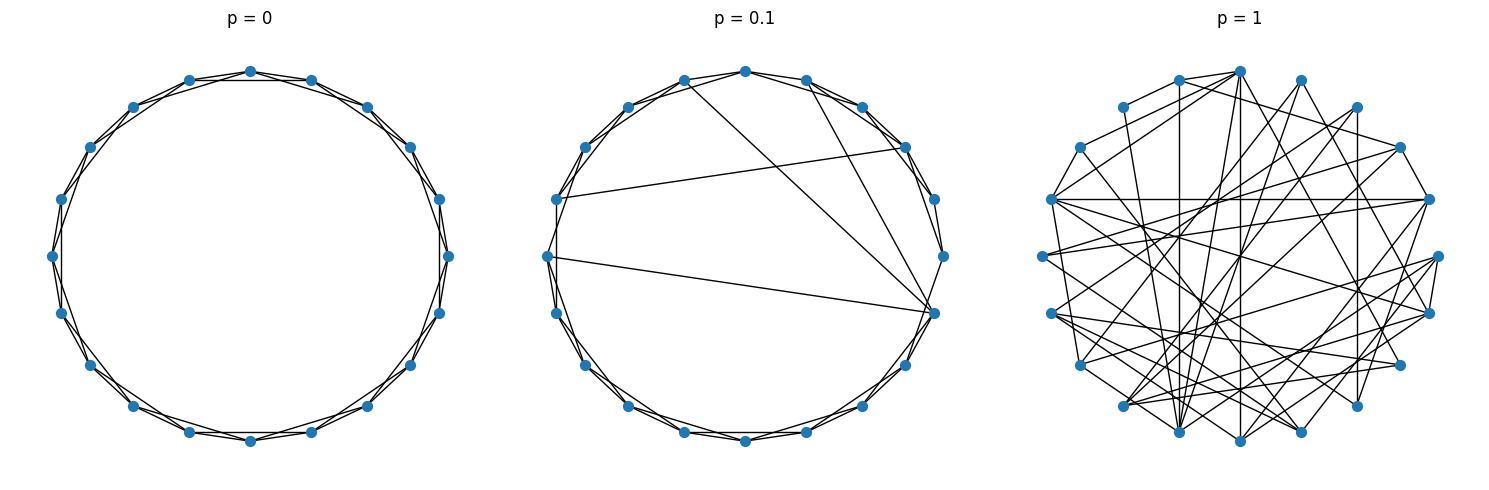

In [17]:
visualize_graphs(N, k, p_values=[0, 0.1, 1])

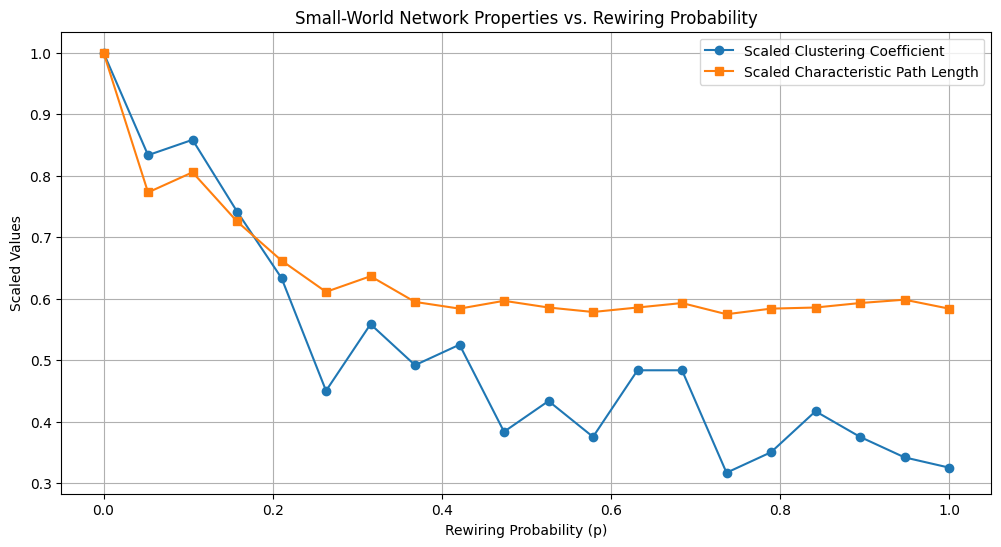

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(p_values, scaled_clustering_coeffs, '-o', label='Scaled Clustering Coefficient')
plt.plot(p_values, scaled_path_lengths, '-s', label='Scaled Characteristic Path Length')
plt.title('Small-World Network Properties vs. Rewiring Probability')
plt.xlabel('Rewiring Probability (p)')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
N = 500  # number of nodes
k = 20    # each node is connected to k nearest neighbors
p_values = np.linspace(0, 1, 20)  # range of p values to explore

# Computing initial values for the regular lattice for scaling
initial_edges = create_regular_lattice(N, k)
initial_clustering = clustering_coefficient(N, initial_edges)
initial_path_length = shortest_path_length(initial_edges, N)

# Arrays to store scaled values
scaled_clustering_coeffs = []
scaled_path_lengths = []

for p in p_values:
    edges = rewire_edges(N, k, p)
    C = clustering_coefficient(N, edges) / initial_clustering
    L = shortest_path_length(edges, N) / initial_path_length
    scaled_clustering_coeffs.append(C)
    scaled_path_lengths.append(L)

In [20]:
# Generating a wider range of p values, including very small ones
p_values_fine = np.logspace(-4, 0, 20)  # Logarithmic scale from 0.0001 to 1

# Arrays to store scaled values for the new p values range
scaled_clustering_coeffs_fine = []
scaled_path_lengths_fine = []

# Recomputing for the new range of p values
for p in p_values_fine:
    edges = rewire_edges(N, k, p)
    C = clustering_coefficient(N, edges) / initial_clustering
    L = shortest_path_length(edges, N) / initial_path_length
    scaled_clustering_coeffs_fine.append(C)
    scaled_path_lengths_fine.append(L)

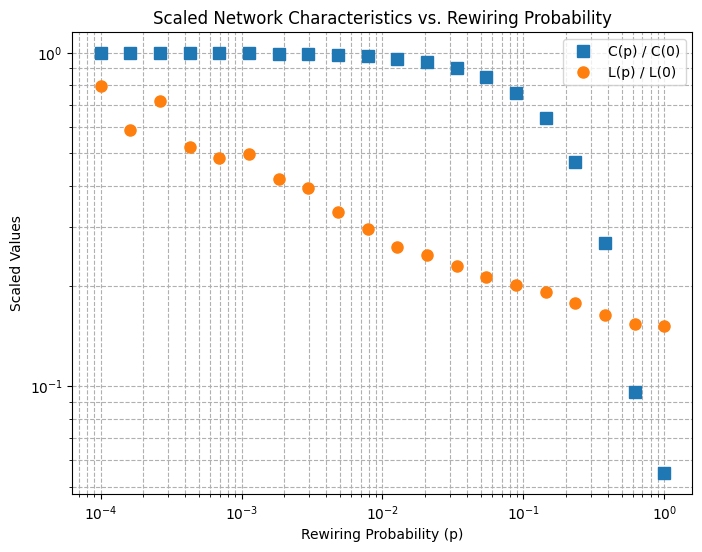

In [21]:
# Plotting both scaled clustering coefficient and scaled characteristic path length
plt.figure(figsize=(8, 6))
plt.loglog(p_values_fine, scaled_clustering_coeffs_fine, 's', label='C(p) / C(0)', markersize=8)
plt.loglog(p_values_fine, scaled_path_lengths_fine, 'o', label='L(p) / L(0)', markersize=8)
plt.title('Scaled Network Characteristics vs. Rewiring Probability')
plt.xlabel('Rewiring Probability (p)')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Answer 2

In [22]:
def add_edge(adjacency_matrix, node1, node2):
    adjacency_matrix[node1].append(node2)
    adjacency_matrix[node2].append(node1)

In [23]:
# Choosing a particular node is directly proportional to its degree relative to the sum of all degrees
def choose_node(node_degrees, m):
    total_degree_sum = sum(node_degrees.values())
    probabilities = {node: degree / total_degree_sum for node, degree in node_degrees.items()}
    chosen_nodes = np.random.choice(
        list(probabilities.keys()),
        size=m,
        replace=False,
        p=list(probabilities.values())
    )
    return chosen_nodes

In [24]:
# Barabasi-Albert (BA) model implementation
def barabasi_albert_graph(n, m0, m):
    if m0 < m: 
        raise Exception("Initial network must have at least m nodes")
    
    # Initialize a small network
    adjacency_matrix = {i: [] for i in range(m0)}
    for i in range(m0):
        for j in range(i + 1, m0):
            add_edge(adjacency_matrix, i, j)
    
    node_degrees = {node: len(adj) for node, adj in adjacency_matrix.items()}
    
    # Add n - m0 new nodes, each with m edges
    for new_node in range(m0, n):
        targets = choose_node(node_degrees, m)
        adjacency_matrix[new_node] = []
        for target in targets:
            add_edge(adjacency_matrix, new_node, target)
        node_degrees[new_node] = m
        for target in targets:
            node_degrees[target] += 1
    
    # Calculate the average clustering coefficient
    clustering_coeffs = []
    for node, adj in adjacency_matrix.items():
        if len(adj) < 2:
            clustering_coeffs.append(0)
            continue
        possible_links = len(adj) * (len(adj) - 1) / 2
        actual_links = 0
        for neighbor in adj:
            for second_neighbor in adjacency_matrix[neighbor]:
                if second_neighbor in adj:
                    actual_links += 1
        clustering_coeffs.append(actual_links / (2 * possible_links))
    
    avg_clustering_coefficient = sum(clustering_coeffs) / len(clustering_coeffs)
    
    return avg_clustering_coefficient, adjacency_matrix

#### a) Average Clustering Coefficient

In [25]:
# Generating 100 instances and compute average clustering coefficients
def simulate_ba_models(num_instances, n_range, m0_range, m_range):
    avg_clustering_coefficients = []
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for _ in range(num_instances):
        avg_coeff, _ = barabasi_albert_graph(n, m0, m)
        avg_clustering_coefficients.append(avg_coeff)
        
    return avg_clustering_coefficients

In [26]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

In [27]:
avg_clustering_coefficients = simulate_ba_models(num_instances, n_range, m0_range, m_range)

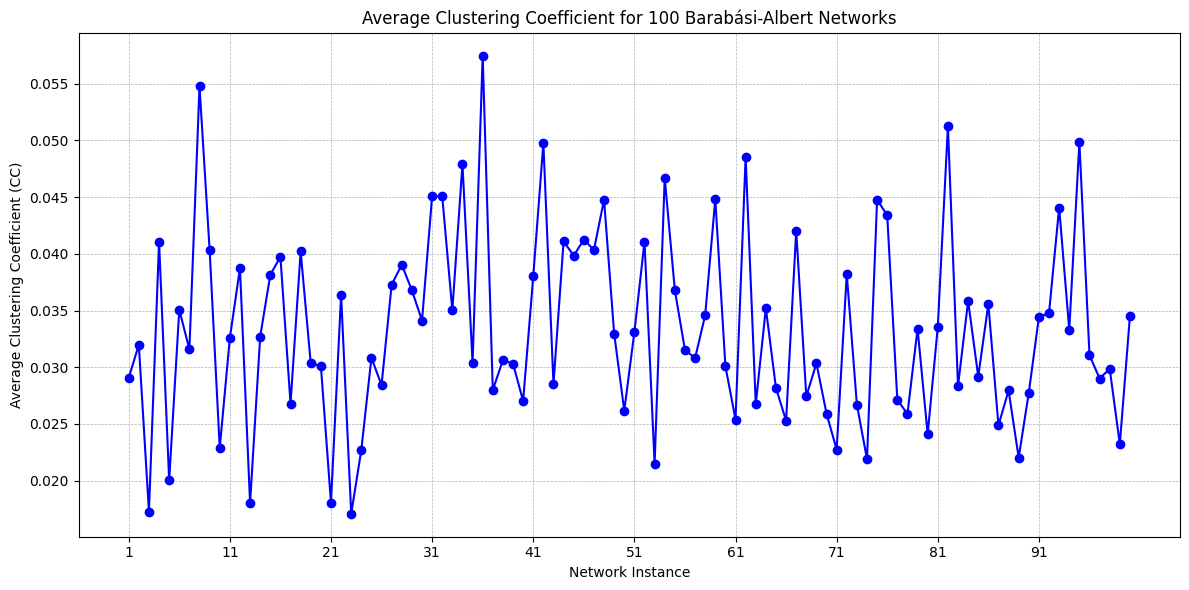

In [28]:
# Generating the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), avg_clustering_coefficients, marker='o', linestyle='-', color='blue')
plt.title('Average Clustering Coefficient for 100 Barabási-Albert Networks')
plt.xlabel('Network Instance')
plt.ylabel('Average Clustering Coefficient (CC)')
plt.xticks(np.arange(1, 101, step=10))  # Show some ticks to avoid clutter
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### (b) Characteristic Path Length

In [29]:
# Function for calculating the shortest path using BFS
def bfs_shortest_path(adjacency_matrix, start_node):
    visited = {node: False for node in adjacency_matrix}
    distance = {node: float('inf') for node in adjacency_matrix}
    queue = deque([start_node])
    distance[start_node] = 0
    visited[start_node] = True
    
    while queue:
        node = queue.popleft()
        for neighbor in adjacency_matrix[node]:
            if not visited[neighbor]:
                queue.append(neighbor)
                visited[neighbor] = True
                distance[neighbor] = distance[node] + 1
    return distance

In [30]:
# Function to calculate the average shortest path length of the network
def average_shortest_path_length(adjacency_matrix):
    total_distance = 0
    total_paths = 0
    
    for node in adjacency_matrix:
        distance = bfs_shortest_path(adjacency_matrix, node)
        for dist in distance.values():
            if dist != float('inf'):
                total_distance += dist
                total_paths += 1
    
    # Subtract self-paths and adjust for double counting
    total_paths -= len(adjacency_matrix)
    return total_distance / total_paths if total_paths else 0

In [31]:
# Modifying the Barabási-Albert model to include characteristic path length calculation
def barabasi_albert_graph_with_path_length(n, m0, m):    
    _, adjacency_matrix = barabasi_albert_graph(n, m0, m)
    avg_path_length = average_shortest_path_length(adjacency_matrix)
    return avg_path_length

In [32]:
# Generate 100 instances and compute average shortest path lengths
def simulate_ba_models_with_path_length(num_instances, n_range, m0_range, m_range):
    path_lengths = []
    
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for _ in range(num_instances):
        path_length = barabasi_albert_graph_with_path_length(n, m0, m)
        path_lengths.append(path_length)
    return path_lengths

In [33]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

In [34]:
characteristic_path_lengths = simulate_ba_models_with_path_length(num_instances, n_range, m0_range, m_range) 

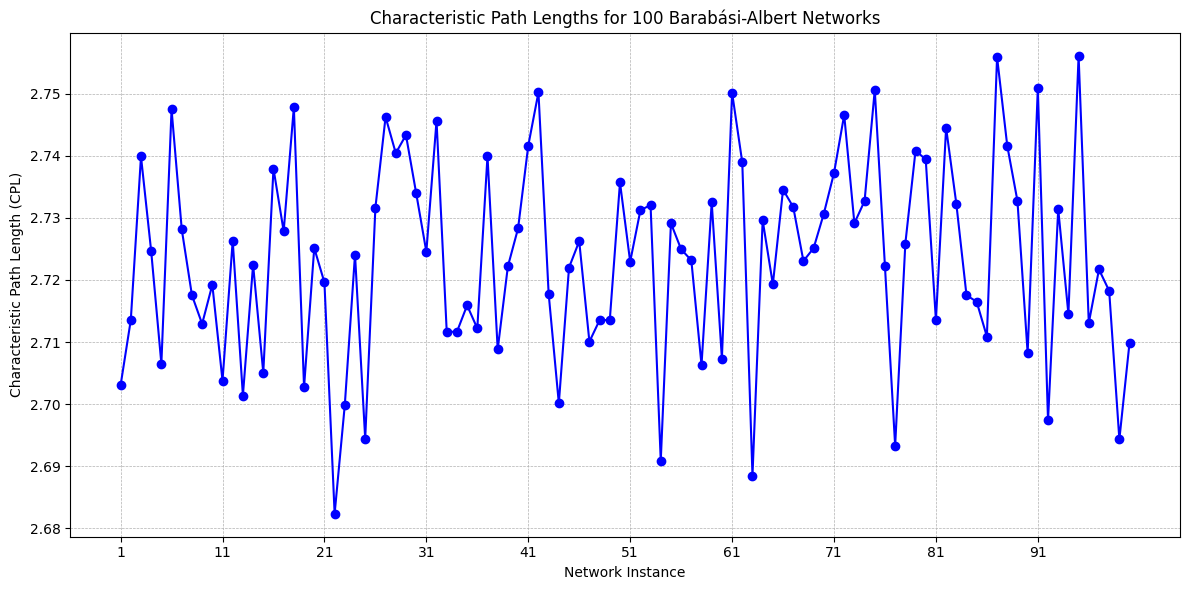

In [35]:
# Generating the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), characteristic_path_lengths, marker='o', linestyle='-', color='blue')
plt.title('Characteristic Path Lengths for 100 Barabási-Albert Networks')
plt.xlabel('Network Instance')
plt.ylabel('Characteristic Path Length (CPL)')
plt.xticks(np.arange(1, 101, step=10)) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### (c) Degree Distribution

In [36]:
# Function to collect degrees from the adjacency matrix
def get_degrees(adjacency_matrix):
    return [len(adj) for adj in adjacency_matrix.values()]

In [37]:
# Generating a single BA network and calculating its degree distribution
def calculate_degree_distribution(n, m0, m):
    _, adjacency_matrix = barabasi_albert_graph(n, m0, m)
    degrees = get_degrees(adjacency_matrix)
    max_degree = max(degrees)
    degree_count = [0] * (max_degree + 1)
    for degree in degrees:
        degree_count[degree] += 1
    degree_distribution = [count / n for count in degree_count]
    return degree_distribution

In [38]:
# Plotting the degree distribution
def plot_degree_distribution(degree_distribution):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_distribution)), degree_distribution, color='blue')
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.title('Degree Distribution of BA Network')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

In [39]:
def plot_degree_distributions_for_ba_networks(num_instances, n_range, m0_range, m_range):
    rows, cols = 20, 5  # Adjust as needed
    fig, axes = plt.subplots(rows, cols, figsize=(20, 40))
    fig.suptitle('Degree Distributions for 100 BA Networks', fontsize=25)
    
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for i in range(num_instances):
        _, adjacency_matrix = barabasi_albert_graph(n, m0, m)
        degrees = [len(adj) for adj in adjacency_matrix.values()]
        max_degree = max(degrees)
        degree_count = [0] * (max_degree + 1)
        for degree in degrees:
            degree_count[degree] += 1
        degree_distribution = [count / n for count in degree_count]
        
        ax = axes[i // cols, i % cols]
        ax.bar(range(len(degree_distribution)), degree_distribution, color='blue')
        ax.set_title(f'Network {i+1}')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Degree')
        ax.set_ylabel('Fraction of Nodes')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [40]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

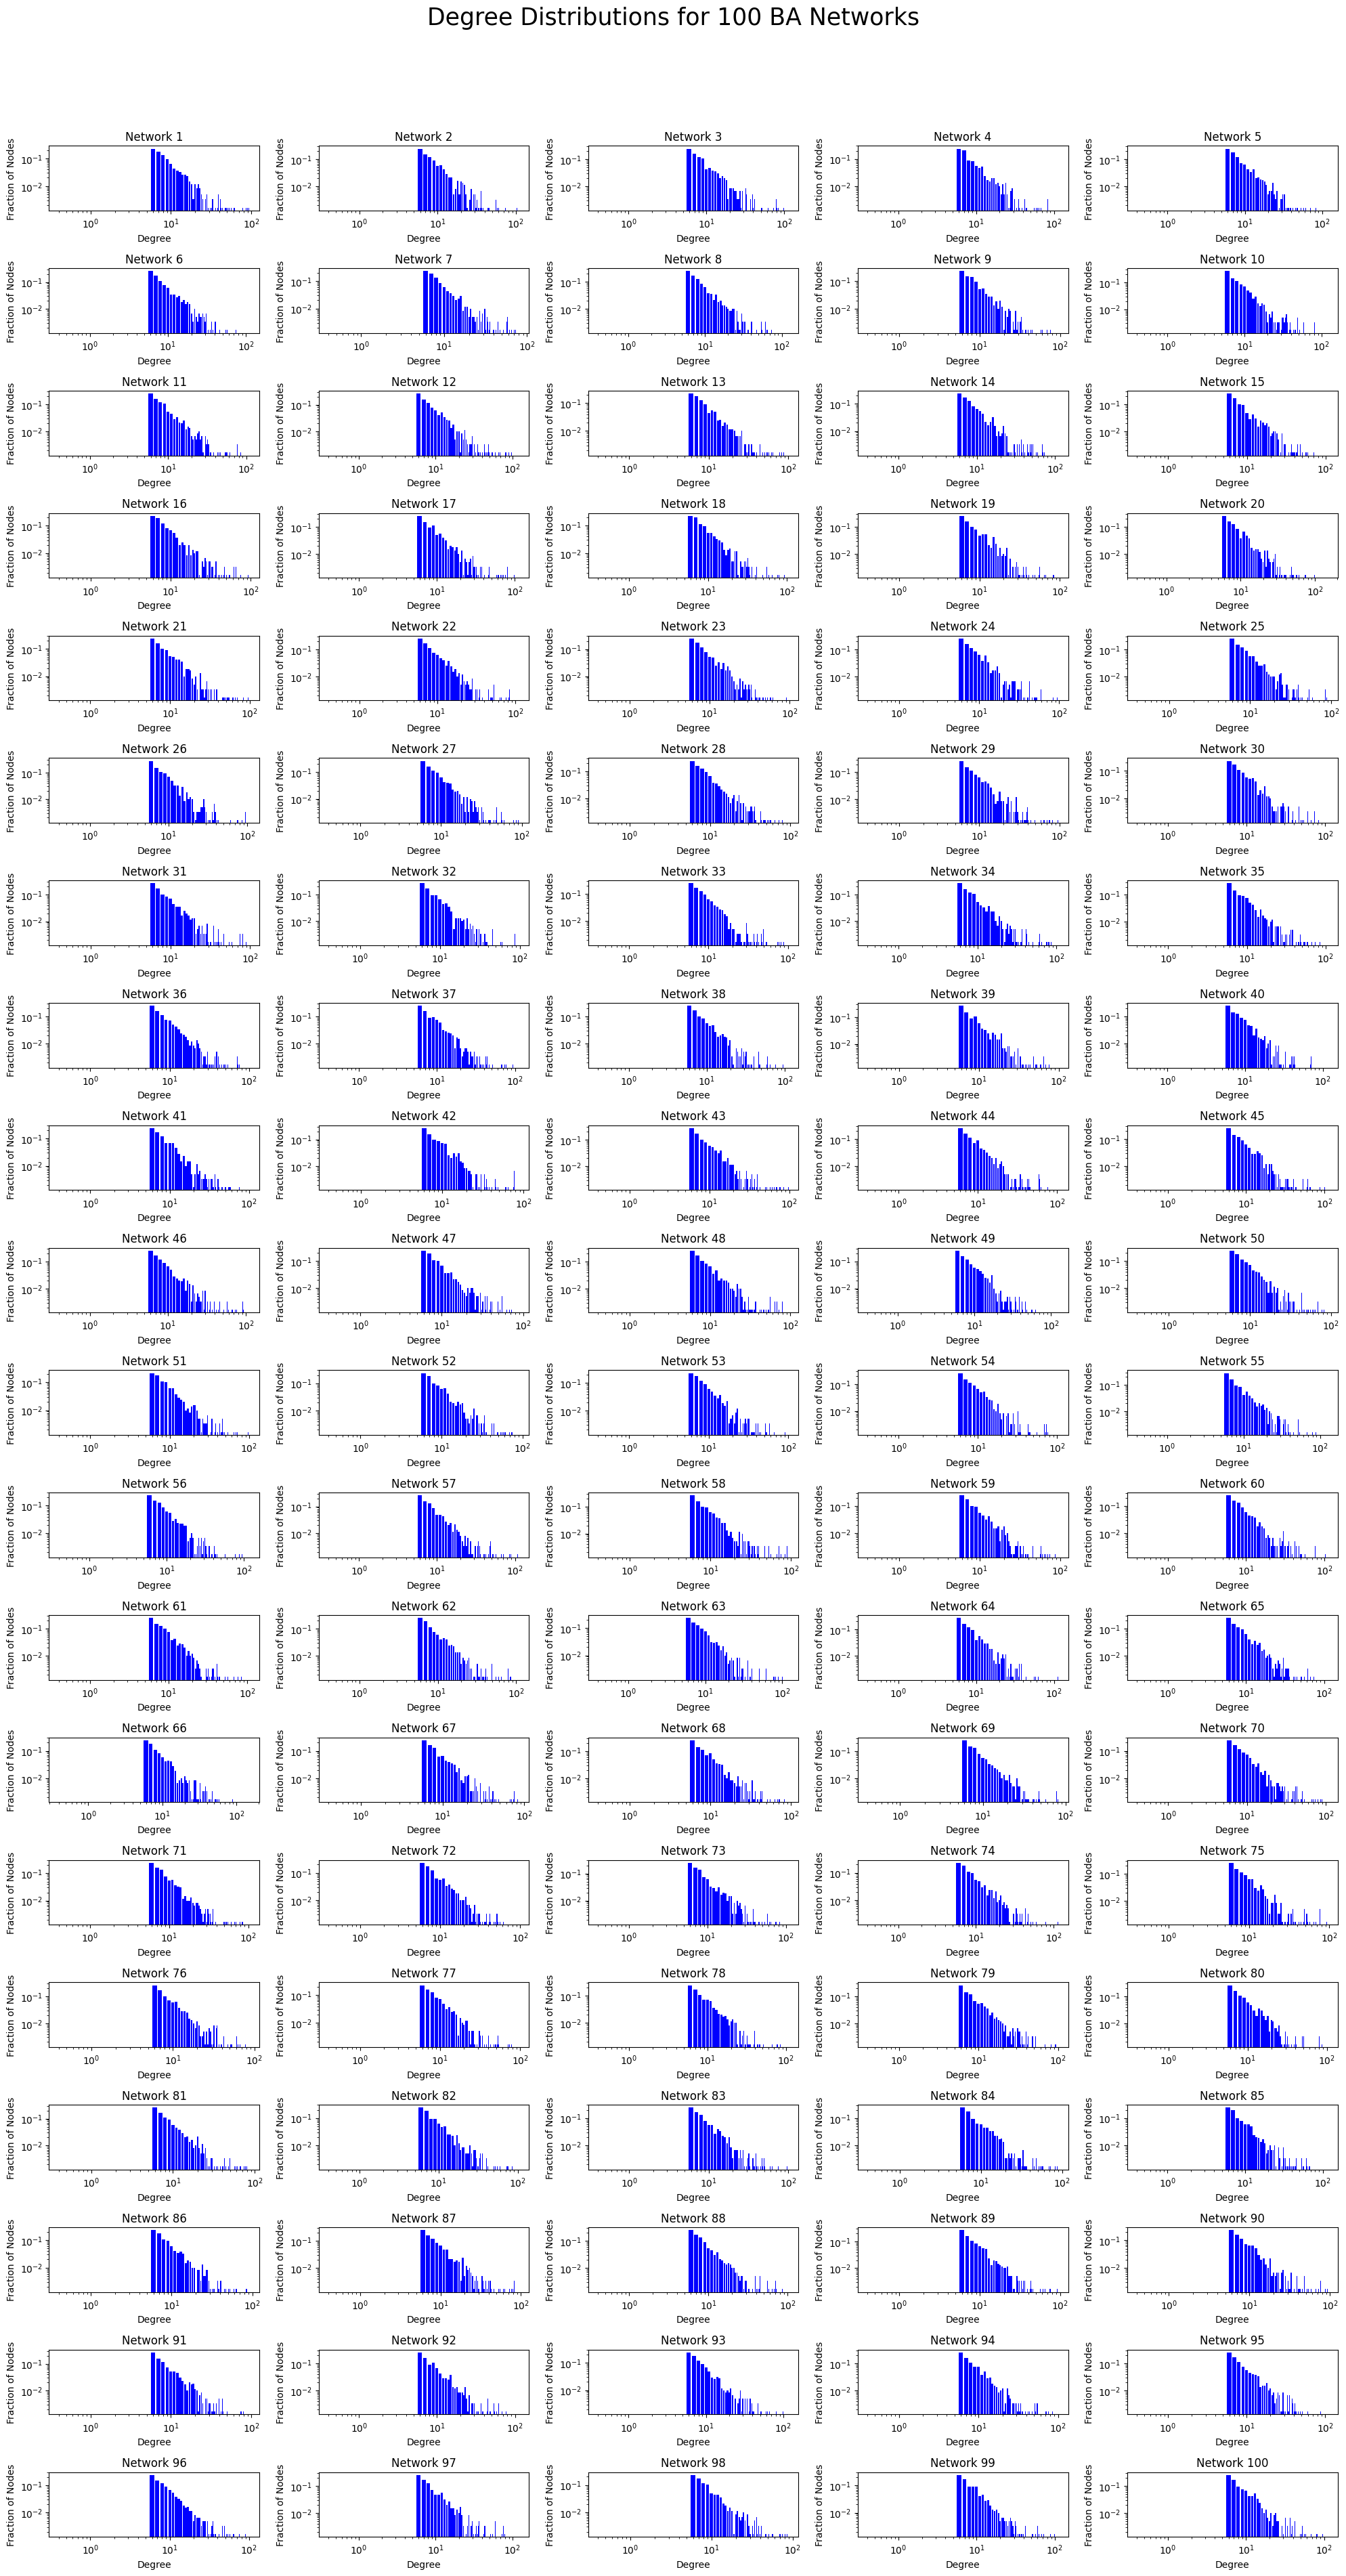

In [41]:
plot_degree_distributions_for_ba_networks(num_instances, n_range, m0_range, m_range)

### Answer 3

In [42]:
# Now the probability of a newly added node getting connected to an existing node is proportional to the square of its degree
def choose_node_squared(node_degrees, m):
    total_degree_sum = sum(degree**2 for degree in node_degrees.values())  # Sum of the squares of the degrees
    probabilities = {node: (degree**2) / total_degree_sum for node, degree in node_degrees.items()}  # Squared probabilities
    chosen_nodes = np.random.choice(
        list(probabilities.keys()),
        size=m,
        replace=False,
        p=list(probabilities.values())
    )
    return list(chosen_nodes)

In [43]:
def barabasi_albert_graph_squared(n, m0, m):
    if m0 < m:
        raise Exception("Initial network must have at least m nodes")
    
    # Initializing a small network
    adjacency_matrix = {i: [] for i in range(m0)}
    for i in range(m0):
        for j in range(i + 1, m0):
            add_edge(adjacency_matrix, i, j)
    
    node_degrees = {node: len(adj) for node, adj in adjacency_matrix.items()}
    
    # Adding n - m0 new nodes, each with m edges, preferentially attached based on degree squared
    for new_node in range(m0, n):
        targets = choose_node_squared(node_degrees, m)
        adjacency_matrix[new_node] = []
        for target in targets:
            add_edge(adjacency_matrix, new_node, target)
            node_degrees[new_node] = node_degrees.get(new_node, 0) + 1
            node_degrees[target] += 1
    
    # Calculating the average clustering coefficient
    clustering_coeffs = []
    for node, adj in adjacency_matrix.items():
        if len(adj) < 2:
            clustering_coeffs.append(0)
            continue
        possible_links = len(adj) * (len(adj) - 1) / 2
        actual_links = 0
        for neighbor in adj:
            for second_neighbor in adjacency_matrix[neighbor]:
                if second_neighbor in adj:
                    actual_links += 1
        clustering_coeffs.append(actual_links / (2 * possible_links))
    
    avg_clustering_coefficient = sum(clustering_coeffs) / len(clustering_coeffs)
    
    return avg_clustering_coefficient, adjacency_matrix

#### a) Average Clustering Coefficient

In [44]:
# Generating 100 instances and compute average clustering coefficients
def simulate_ba_models(num_instances, n_range, m0_range, m_range):
    avg_clustering_coefficients = []
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for _ in range(num_instances):
        avg_coeff, _ = barabasi_albert_graph_squared(n, m0, m)
        avg_clustering_coefficients.append(avg_coeff)
        
    return avg_clustering_coefficients

In [45]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

In [46]:
avg_clustering_coefficients = simulate_ba_models(num_instances, n_range, m0_range, m_range)

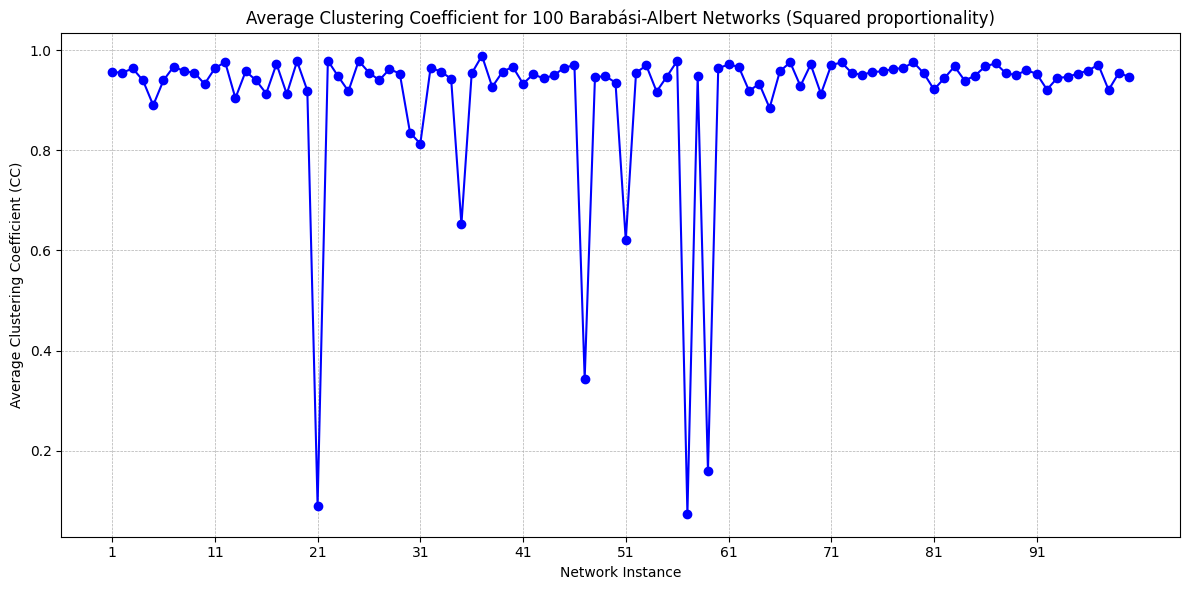

In [47]:
# Generating the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), avg_clustering_coefficients, marker='o', linestyle='-', color='blue')
plt.title('Average Clustering Coefficient for 100 Barabási-Albert Networks (Squared proportionality)')
plt.xlabel('Network Instance')
plt.ylabel('Average Clustering Coefficient (CC)')
plt.xticks(np.arange(1, 101, step=10))  # Show some ticks to avoid clutter
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### (b) Characteristic Path Length

In [48]:
# Function for calculating the shortest path using BFS
def bfs_shortest_path(adjacency_matrix, start_node):
    visited = {node: False for node in adjacency_matrix}
    distance = {node: float('inf') for node in adjacency_matrix}
    queue = deque([start_node])
    distance[start_node] = 0
    visited[start_node] = True
    
    while queue:
        node = queue.popleft()
        for neighbor in adjacency_matrix[node]:
            if not visited[neighbor]:
                queue.append(neighbor)
                visited[neighbor] = True
                distance[neighbor] = distance[node] + 1
    return distance

In [49]:
# Function to calculate the average shortest path length of the network
def average_shortest_path_length(adjacency_matrix):
    total_distance = 0
    total_paths = 0
    
    for node in adjacency_matrix:
        distance = bfs_shortest_path(adjacency_matrix, node)
        for dist in distance.values():
            if dist != float('inf'):
                total_distance += dist
                total_paths += 1
    
    # Subtract self-paths and adjust for double counting
    total_paths -= len(adjacency_matrix)
    return total_distance / total_paths if total_paths else 0

In [50]:
# Modifying the Barabási-Albert model to include characteristic path length calculation
def barabasi_albert_graph_with_path_length(n, m0, m):    
    _, adjacency_matrix = barabasi_albert_graph_squared(n, m0, m)
    avg_path_length = average_shortest_path_length(adjacency_matrix)
    return avg_path_length

In [51]:
# Generate 100 instances and compute average shortest path lengths
def simulate_ba_models_with_path_length(num_instances, n_range, m0_range, m_range):
    path_lengths = []
    
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for _ in range(num_instances):
        path_length = barabasi_albert_graph_with_path_length(n, m0, m)
        path_lengths.append(path_length)
    return path_lengths

In [52]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

In [53]:
characteristic_path_lengths = simulate_ba_models_with_path_length(num_instances, n_range, m0_range, m_range) 

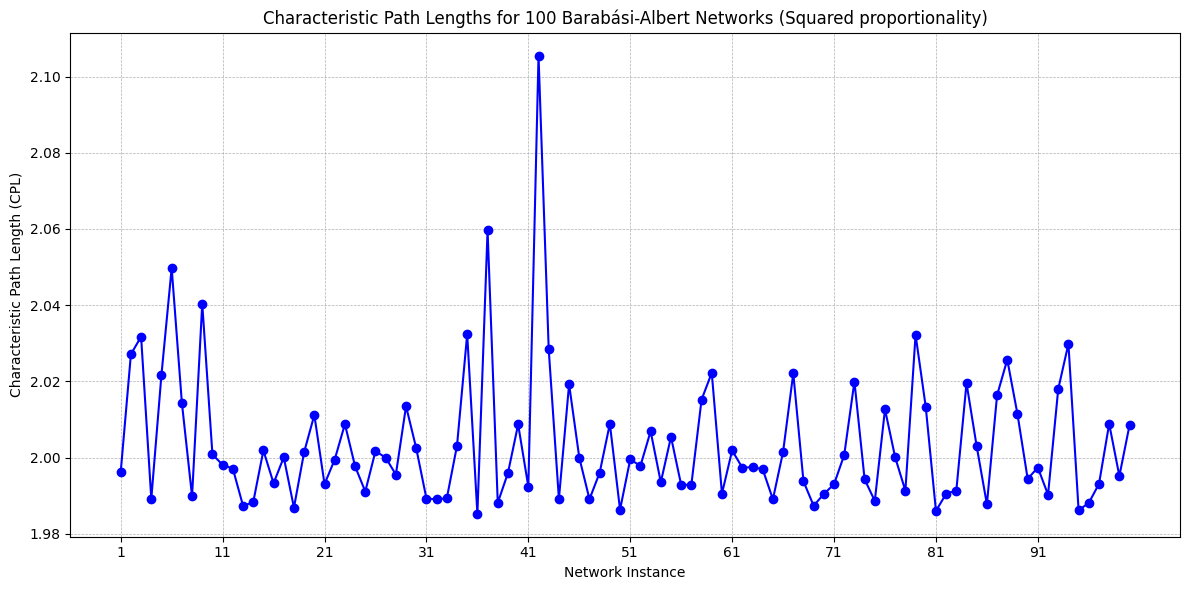

In [54]:
# Generating the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), characteristic_path_lengths, marker='o', linestyle='-', color='blue')
plt.title('Characteristic Path Lengths for 100 Barabási-Albert Networks (Squared proportionality)')
plt.xlabel('Network Instance')
plt.ylabel('Characteristic Path Length (CPL)')
plt.xticks(np.arange(1, 101, step=10)) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### (c) Degree Distribution

In [80]:
# Function to collect degrees from the adjacency matrix
def get_degrees(adjacency_matrix):
    return [len(adj) for adj in adjacency_matrix.values()]

In [81]:
# Generating a single BA network and calculating its degree distribution
def calculate_degree_distribution(n, m0, m):
    _, adjacency_matrix = barabasi_albert_graph_squared(n, m0, m)
    degrees = get_degrees(adjacency_matrix)
    max_degree = max(degrees)
    degree_count = [0] * (max_degree + 1)
    for degree in degrees:
        degree_count[degree] += 1
    degree_distribution = [count / n for count in degree_count]
    return degree_distribution

In [82]:
# Plotting the degree distribution
def plot_degree_distribution(degree_distribution):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_distribution)), degree_distribution, color='blue')
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.title('Degree Distribution of BA Network')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

In [83]:
def plot_degree_distributions_for_ba_networks(num_instances, n_range, m0_range, m_range):
    rows, cols = 20, 5  # Adjust as needed
    fig, axes = plt.subplots(rows, cols, figsize=(20, 40))
    fig.suptitle('Degree Distributions for 100 BA Networks (Squared proportionality)', fontsize=25)
    
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for i in range(num_instances):
        _, adjacency_matrix = barabasi_albert_graph_squared(n, m0, m)
        degrees = [len(adj) for adj in adjacency_matrix.values()]
        max_degree = max(degrees)
        degree_count = [0] * (max_degree + 1)
        for degree in degrees:
            degree_count[degree] += 1
        degree_distribution = [count / n for count in degree_count]
        
        ax = axes[i // cols, i % cols]
        ax.bar(range(len(degree_distribution)), degree_distribution, color='blue')
        ax.set_title(f'Network {i+1}')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Degree')
        ax.set_ylabel('Fraction of Nodes')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [84]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

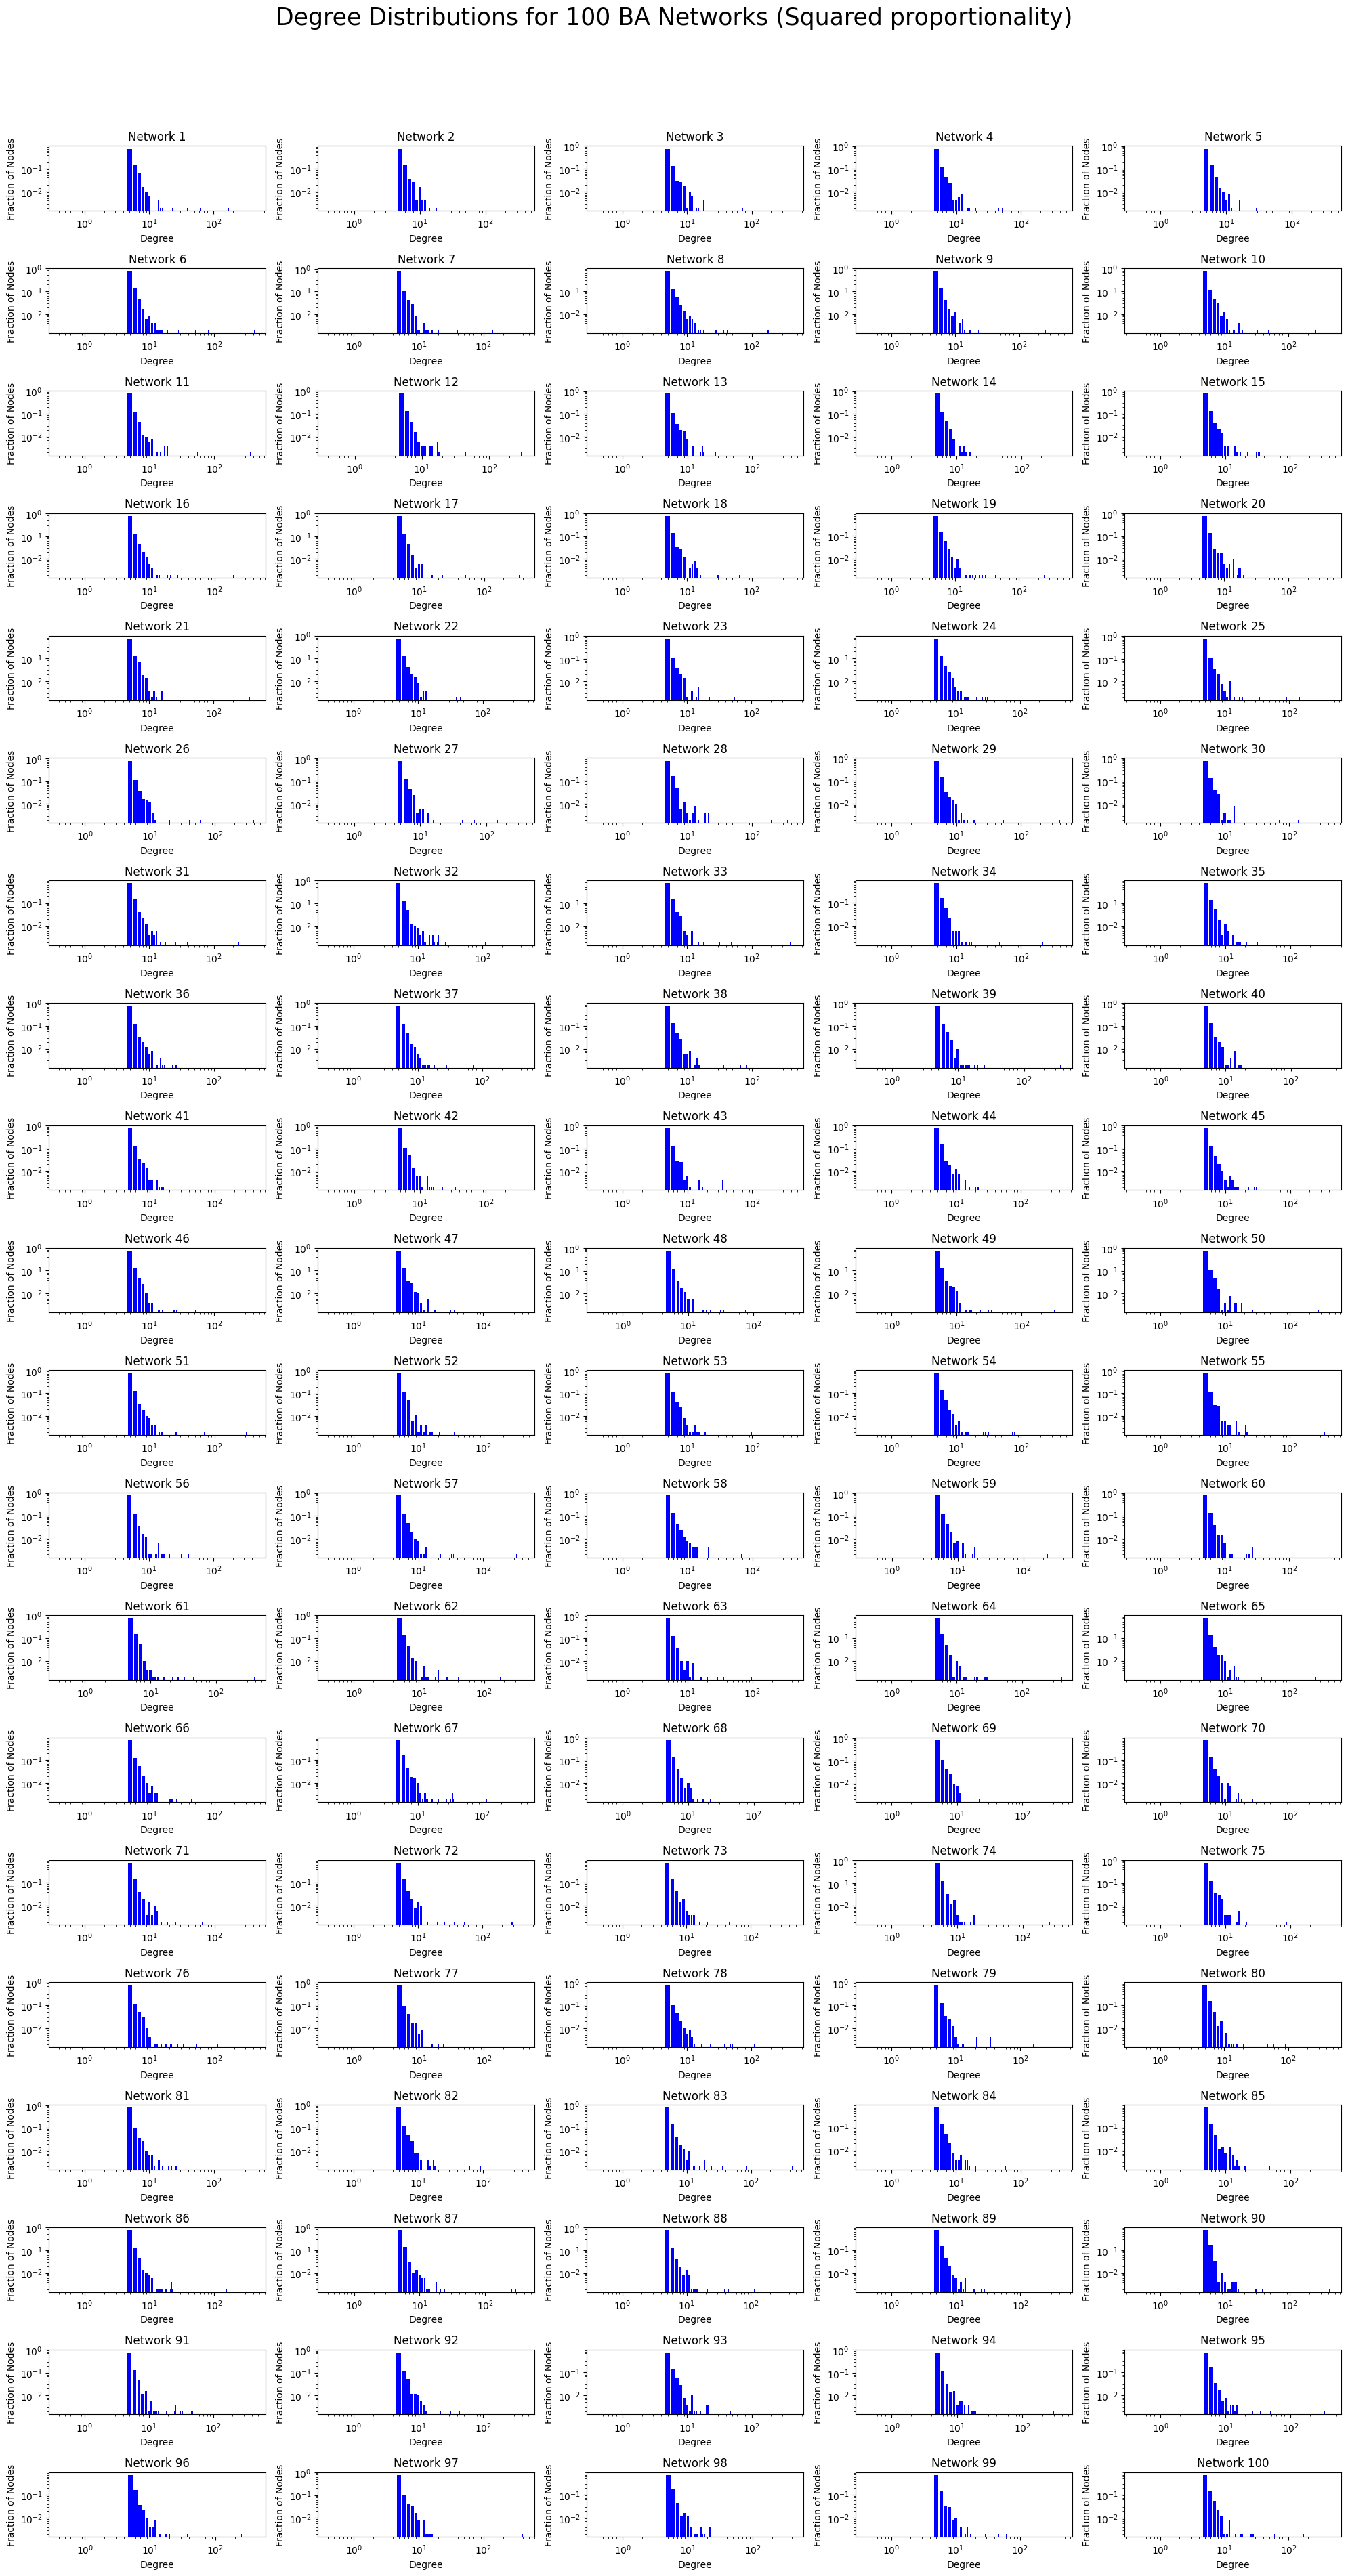

In [85]:
plot_degree_distributions_for_ba_networks(num_instances, n_range, m0_range, m_range)

#### Analysis and assessment of the topology

The two models implemented are:

1. **Original BA Model (Linear Proportionality):** The probability of a newly added node connecting to an existing node is proportional to the degree of the existing node.

2. **Modified BA Model (Squared Proportionality):** The probability of a newly added node connecting to an existing node is proportional to the square of the degree of the existing node.

Here are some observations and comparisons deduced from the above generated graphs:

- **Average Clustering Coefficient (CC):**
   - In the original model, the CC values fluctuate within a certain range without extreme outliers. This is typical for scale-free networks where the hubs are connected, but there is a limit to the local cliquishness due to the linear preferential attachment.
   - In the modified model with squared proportionality, there is an increase in variance with some instances showing significantly higher CC values. This suggests that nodes tend to form more tight-knit communities (cliques) around the hubs, likely due to the intensified preference for already highly connected nodes.

- **Characteristic Path Length (CPL):**
   - The original model displays relatively stable CPL values, indicating that the average shortest paths between nodes do not vary drastically across instances. This is consistent with the small-world phenomenon typical of scale-free networks.
   - The modified model shows a similar stability in CPL values, but with a tendency towards shorter paths on average. This could result from the formation of super-hubs—nodes with exceptionally high degrees—that effectively reduce the distance between any two nodes in the network.

- **Degree Distributions:**
   - The degree distribution plots for the original BA model typically show a tail that follows a power-law distribution, characteristic of scale-free networks. Most nodes have a few connections, while a small number of hubs have many connections.
   - In the modified model, the degree distribution shows a more pronounced skewness towards higher degrees. The rich-get-richer effect is intensified, leading to a more extreme disparity where a few nodes become super-hubs, far surpassing the rest in connectivity.

In summary, when the preferential attachment is squared, the rich-get-richer phenomenon is indeed accentuated. The network becomes more centralized around a few super-hubs, leading to higher local clustering and potentially shorter path lengths due to the increased centrality of the network's structure. This change can make the network more robust to random failures (as it's even more resilient due to the super-hubs) but may also make it more vulnerable to targeted attacks, as a few nodes become critical to the network's integrity.

#### Variant of higher order (proportional to 4th order)

In [61]:
def choose_node_fourth_power(node_degrees, m):
    total_degree_sum = sum(degree**4 for degree in node_degrees.values())  # Sum of the fourth powers of the degrees
    probabilities = {node: (degree**4) / total_degree_sum for node, degree in node_degrees.items()}  # Fourth power probabilities
    chosen_nodes = np.random.choice(
        list(probabilities.keys()),
        size=m,
        replace=False,
        p=list(probabilities.values())
    )
    return list(chosen_nodes)

In [62]:
def barabasi_albert_graph_fourth_power(n, m0, m):
    if m0 < m:
        raise Exception("Initial network must have at least m nodes")
    
    # Same initialization as before
    adjacency_matrix = {i: [] for i in range(m0)}
    for i in range(m0):
        for j in range(i + 1, m0):
            add_edge(adjacency_matrix, i, j)
    
    node_degrees = {node: len(adj) for node, adj in adjacency_matrix.items()}
    
    # Adding new nodes with preferential attachment based on degree to the 4th power
    for new_node in range(m0, n):
        targets = choose_node_fourth_power(node_degrees, m)
        adjacency_matrix[new_node] = []
        for target in targets:
            add_edge(adjacency_matrix, new_node, target)
            node_degrees[new_node] = node_degrees.get(new_node, 0) + 1
            node_degrees[target] += 1
    
    # Same clustering coefficient calculation
    clustering_coeffs = []
    for node, adj in adjacency_matrix.items():
        if len(adj) < 2:
            clustering_coeffs.append(0)
            continue
        possible_links = len(adj) * (len(adj) - 1) / 2
        actual_links = 0
        for neighbor in adj:
            for second_neighbor in adjacency_matrix[neighbor]:
                if second_neighbor in adj:
                    actual_links += 1
        clustering_coeffs.append(actual_links / (2 * possible_links))
    
    avg_clustering_coefficient = sum(clustering_coeffs) / len(clustering_coeffs)
    
    return avg_clustering_coefficient, adjacency_matrix

#### a) Average Clustering Coefficient

In [63]:
# Generating 100 instances and compute average clustering coefficients
def simulate_ba_models(num_instances, n_range, m0_range, m_range):
    avg_clustering_coefficients = []
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for _ in range(num_instances):
        avg_coeff, _ = barabasi_albert_graph_fourth_power(n, m0, m)
        avg_clustering_coefficients.append(avg_coeff)
        
    return avg_clustering_coefficients

In [64]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

In [65]:
avg_clustering_coefficients = simulate_ba_models(num_instances, n_range, m0_range, m_range)

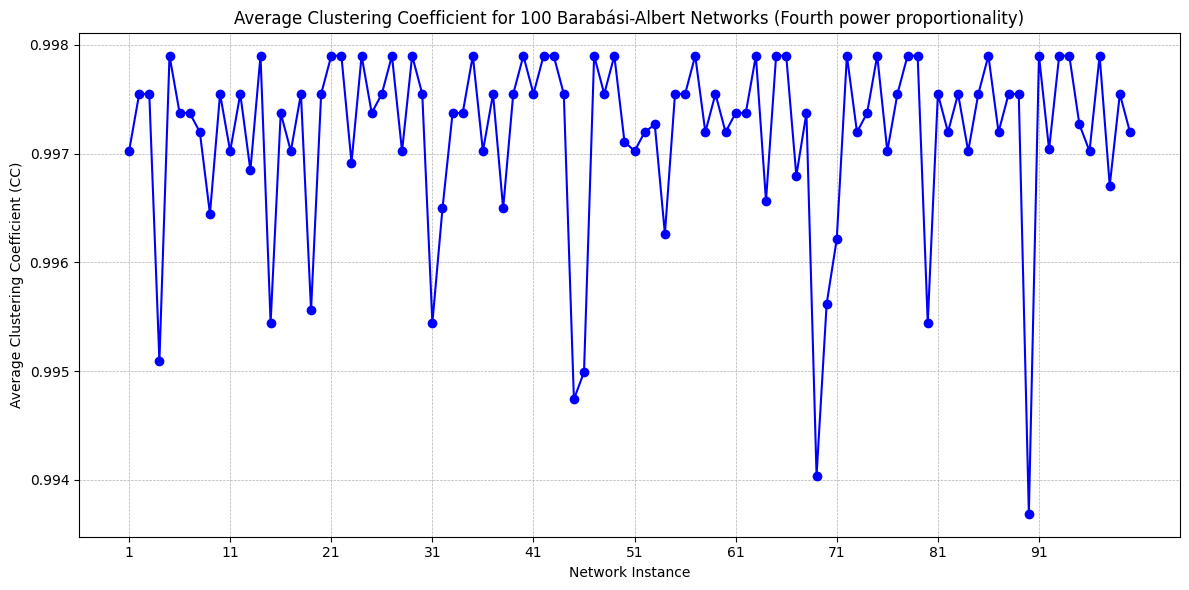

In [66]:
# Generating the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), avg_clustering_coefficients, marker='o', linestyle='-', color='blue')
plt.title('Average Clustering Coefficient for 100 Barabási-Albert Networks (Fourth power proportionality)')
plt.xlabel('Network Instance')
plt.ylabel('Average Clustering Coefficient (CC)')
plt.xticks(np.arange(1, 101, step=10))  # Show some ticks to avoid clutter
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### (b) Characteristic Path Length

In [67]:
# Function for calculating the shortest path using BFS
def bfs_shortest_path(adjacency_matrix, start_node):
    visited = {node: False for node in adjacency_matrix}
    distance = {node: float('inf') for node in adjacency_matrix}
    queue = deque([start_node])
    distance[start_node] = 0
    visited[start_node] = True
    
    while queue:
        node = queue.popleft()
        for neighbor in adjacency_matrix[node]:
            if not visited[neighbor]:
                queue.append(neighbor)
                visited[neighbor] = True
                distance[neighbor] = distance[node] + 1
    return distance

In [68]:
# Function to calculate the average shortest path length of the network
def average_shortest_path_length(adjacency_matrix):
    total_distance = 0
    total_paths = 0
    
    for node in adjacency_matrix:
        distance = bfs_shortest_path(adjacency_matrix, node)
        for dist in distance.values():
            if dist != float('inf'):
                total_distance += dist
                total_paths += 1
    
    # Subtract self-paths and adjust for double counting
    total_paths -= len(adjacency_matrix)
    return total_distance / total_paths if total_paths else 0

In [69]:
# Modifying the Barabási-Albert model to include characteristic path length calculation
def barabasi_albert_graph_with_path_length(n, m0, m):    
    _, adjacency_matrix = barabasi_albert_graph_fourth_power(n, m0, m)
    avg_path_length = average_shortest_path_length(adjacency_matrix)
    return avg_path_length

In [70]:
# Generate 100 instances and compute average shortest path lengths
def simulate_ba_models_with_path_length(num_instances, n_range, m0_range, m_range):
    path_lengths = []
    
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for _ in range(num_instances):
        path_length = barabasi_albert_graph_with_path_length(n, m0, m)
        path_lengths.append(path_length)
    return path_lengths

In [71]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

In [72]:
characteristic_path_lengths = simulate_ba_models_with_path_length(num_instances, n_range, m0_range, m_range) 

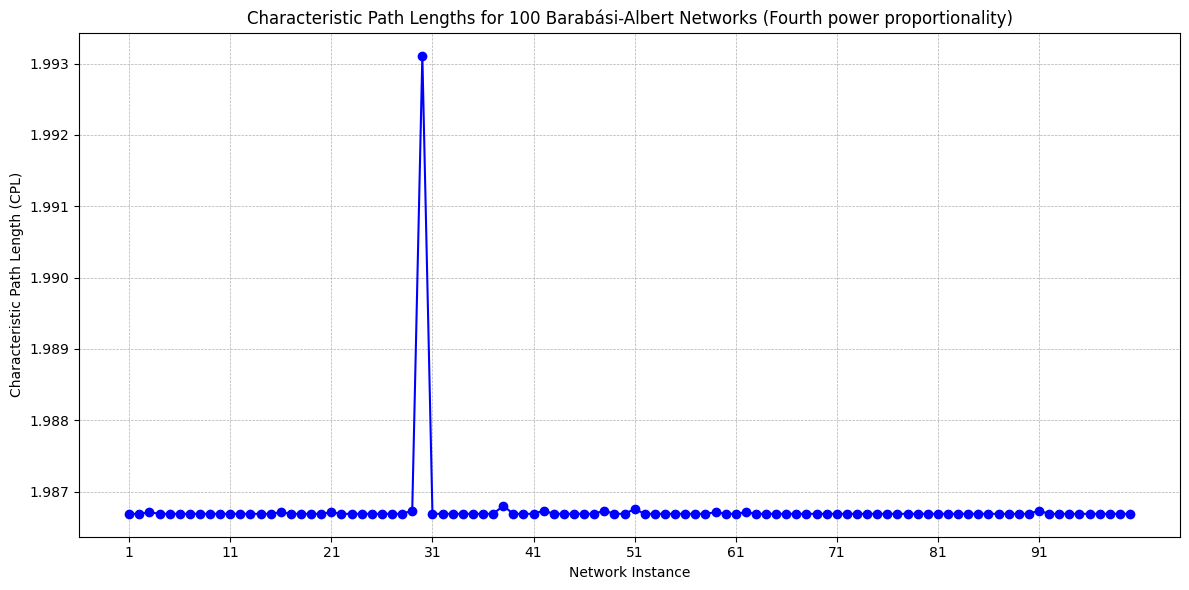

In [73]:
# Generating the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), characteristic_path_lengths, marker='o', linestyle='-', color='blue')
plt.title('Characteristic Path Lengths for 100 Barabási-Albert Networks (Fourth power proportionality)')
plt.xlabel('Network Instance')
plt.ylabel('Characteristic Path Length (CPL)')
plt.xticks(np.arange(1, 101, step=10)) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### (c) Degree Distribution

In [74]:
# Function to collect degrees from the adjacency matrix
def get_degrees(adjacency_matrix):
    return [len(adj) for adj in adjacency_matrix.values()]

In [75]:
# Generating a single BA network and calculating its degree distribution
def calculate_degree_distribution(n, m0, m):
    _, adjacency_matrix = barabasi_albert_graph_fourth_power(n, m0, m)
    degrees = get_degrees(adjacency_matrix)
    max_degree = max(degrees)
    degree_count = [0] * (max_degree + 1)
    for degree in degrees:
        degree_count[degree] += 1
    degree_distribution = [count / n for count in degree_count]
    return degree_distribution

In [76]:
# Plotting the degree distribution
def plot_degree_distribution(degree_distribution):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_distribution)), degree_distribution, color='blue')
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.title('Degree Distribution of BA Network')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

In [77]:
def plot_degree_distributions_for_ba_networks(num_instances, n_range, m0_range, m_range):
    rows, cols = 20, 5  # Adjust as needed
    fig, axes = plt.subplots(rows, cols, figsize=(20, 40))
    fig.suptitle('Degree Distributions for 100 BA Networks (Squared proportionality)', fontsize=25)
    
    m0 = random.choice(m0_range)  # Choosing initial network size
    n = random.choice(n_range)  # Choosing number of nodes
    m = random.choice(m_range)  # Choosing number of edges
    
    # Ensuring n is greater than m0 and m to avoid errors in network generation
    m = min(m, m0)
    n = max(n, m0 + m + 1)
    
    for i in range(num_instances):
        _, adjacency_matrix = barabasi_albert_graph_fourth_power(n, m0, m)
        degrees = [len(adj) for adj in adjacency_matrix.values()]
        max_degree = max(degrees)
        degree_count = [0] * (max_degree + 1)
        for degree in degrees:
            degree_count[degree] += 1
        degree_distribution = [count / n for count in degree_count]
        
        ax = axes[i // cols, i % cols]
        ax.bar(range(len(degree_distribution)), degree_distribution, color='blue')
        ax.set_title(f'Network {i+1}')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Degree')
        ax.set_ylabel('Fraction of Nodes')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [78]:
# Varying the parameters of the model
m0_range = range(2, 10)  # Range of initial network sizes
n_range = range(100, 1001, 50)  # Range of number of nodes
m_range = range(1, 9)  # Range of number of edges
num_instances = 100

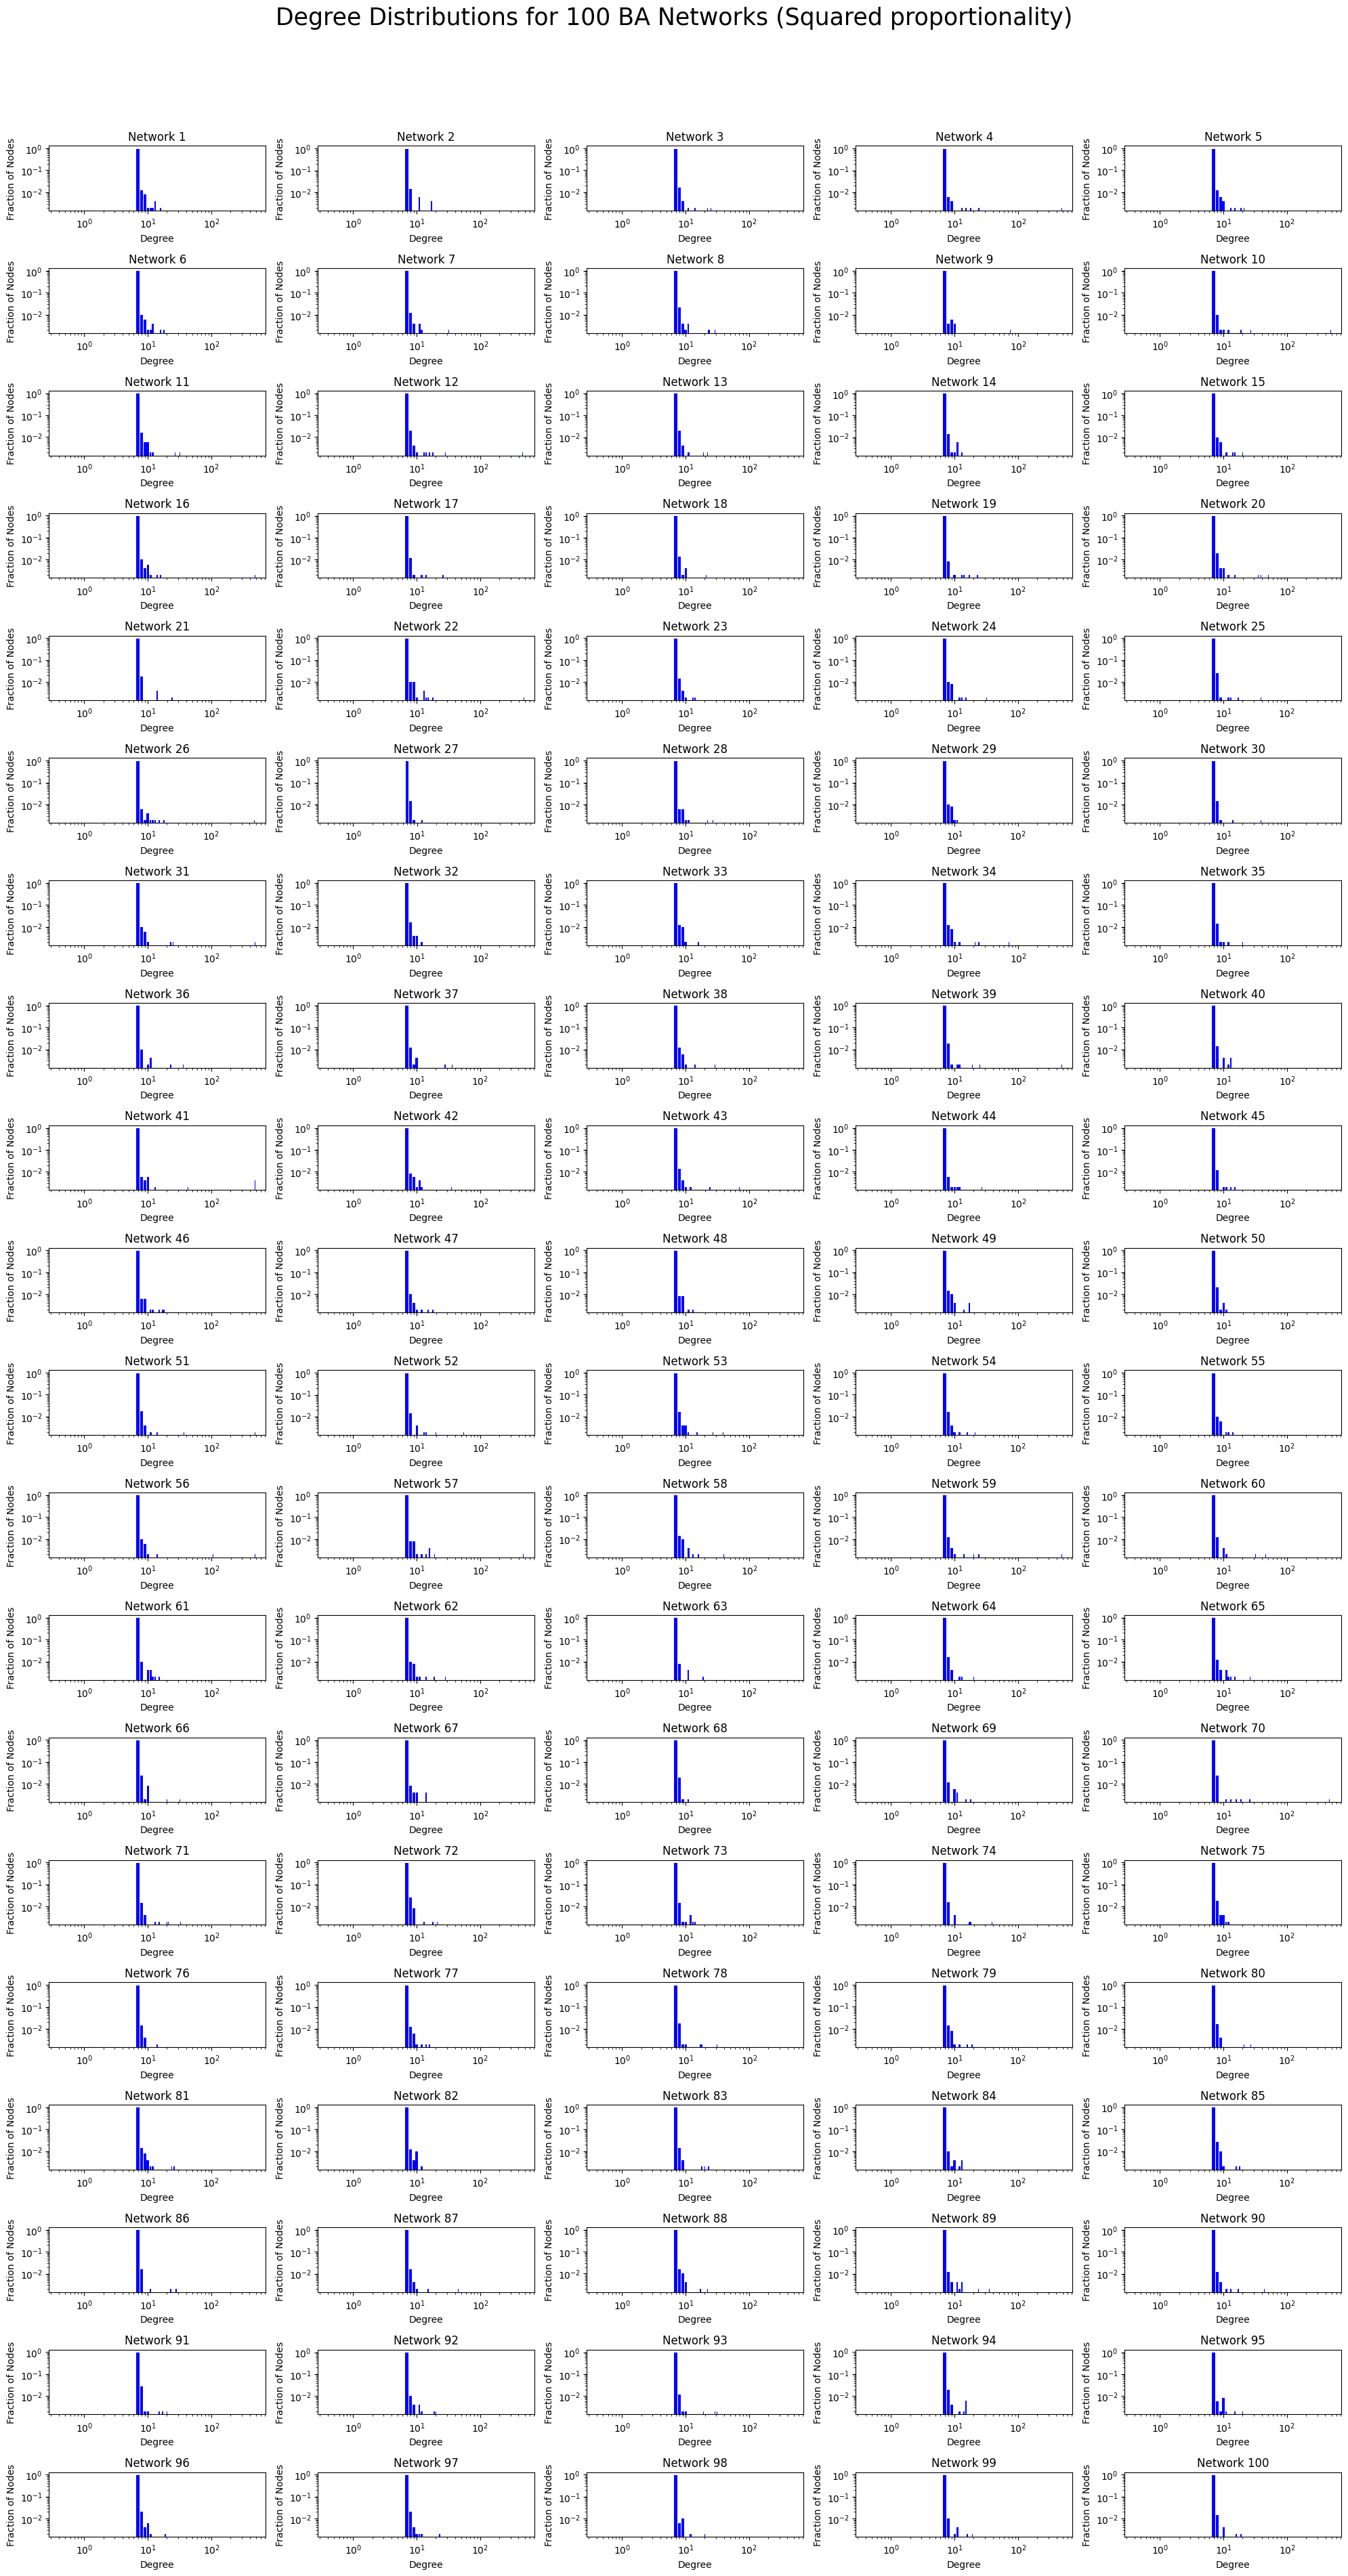

In [79]:
plot_degree_distributions_for_ba_networks(num_instances, n_range, m0_range, m_range)

### Answer 4

#### a)

In [86]:
def simulate_random_deletion(network, fractions):
    original_size = network.number_of_nodes()
    path_lengths = []
    giant_cluster_sizes = []
    
    for f in fractions:
        # Clone the original network for each fraction f to remove nodes
        temp_network = network.copy()
        nodes_to_remove = sample(list(temp_network.nodes()), int(np.ceil(f * original_size)))
        temp_network.remove_nodes_from(nodes_to_remove)
        
        # Calculate the size of the giant cluster
        giant_cluster = max(nx.connected_components(temp_network), key=len)
        giant_cluster_size = len(giant_cluster)
        giant_cluster_sizes.append(giant_cluster_size / original_size)
        
        # Calculate characteristic path length of the giant cluster
        if giant_cluster_size > 1:
            giant_cluster_graph = temp_network.subgraph(giant_cluster)
            path_length = nx.average_shortest_path_length(giant_cluster_graph)
            path_lengths.append(path_length)
        else:
            path_lengths.append(float('inf'))  # Network is too disconnected
    
    return path_lengths, giant_cluster_sizes

In [87]:
network = nx.barabasi_albert_graph(1000, 4)  # Network with 1000 nodes, m=4

# Fractions of nodes to remove
fractions = np.linspace(0, 0.9, 10)

# Simulating random deletion
path_lengths, giant_cluster_sizes = simulate_random_deletion(network, fractions)

In [90]:
print(f'The sizes of the giant clusters are: {giant_cluster_sizes}')

The sizes of the giant clusters are: [1.0, 0.9, 0.799, 0.697, 0.588, 0.485, 0.357, 0.242, 0.137, 0.015]


In [91]:
print(f'The biggest cluster has a size equivalent to: {max(giant_cluster_sizes)}')

The biggest cluster has a size equivalent to: 1.0


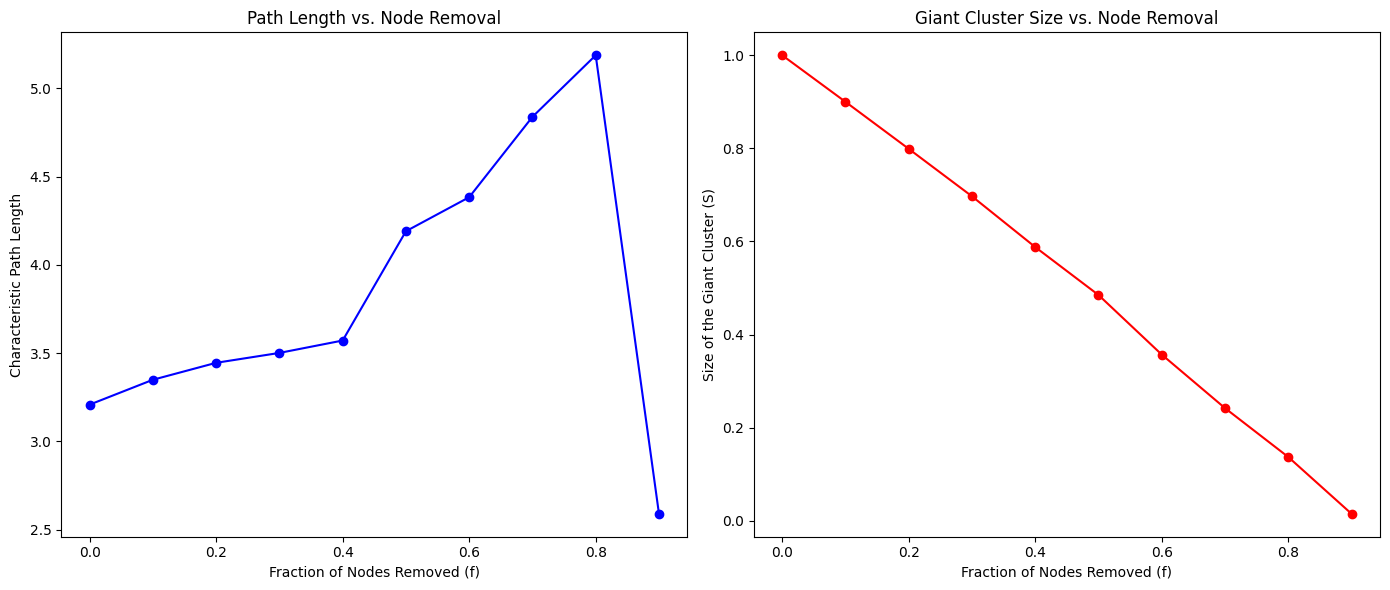

In [92]:
# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fractions, path_lengths, marker='o', linestyle='-', color='blue')
plt.xlabel('Fraction of Nodes Removed (f)')
plt.ylabel('Characteristic Path Length')
plt.title('Path Length vs. Node Removal')

plt.subplot(1, 2, 2)
plt.plot(fractions, giant_cluster_sizes, marker='o', linestyle='-', color='red')
plt.xlabel('Fraction of Nodes Removed (f)')
plt.ylabel('Size of the Giant Cluster (S)')
plt.title('Giant Cluster Size vs. Node Removal')

plt.tight_layout()
plt.show()

#### b)

In [93]:
def deletion_simulation(network, fractions, strategy='random'):
    assert strategy in ['random', 'targeted']
    original_size = len(network)
    path_lengths = []
    giant_cluster_sizes = []
    
    for f in fractions:
        # Cloning the original network for each fraction f
        temp_network = network.copy()
        
        # Determining nodes to remove
        if strategy == 'random':
            nodes_to_remove = sample(list(temp_network.nodes()), int(np.ceil(f * original_size)))
        elif strategy == 'targeted':
            sorted_nodes = sorted(temp_network.degree, key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node for node, degree in sorted_nodes][:int(np.ceil(f * original_size))]
        
        # Removing nodes
        temp_network.remove_nodes_from(nodes_to_remove)
        
        # Calculating the size of the giant cluster
        if len(temp_network) > 0:
            giant_cluster = max(nx.connected_components(temp_network), key=len)
            giant_cluster_size = len(giant_cluster)
            giant_cluster_sizes.append(giant_cluster_size / original_size)
        else:
            giant_cluster_sizes.append(0)
        
        # Calculating characteristic path length of the giant cluster
        if giant_cluster_size > 1:
            giant_cluster_graph = temp_network.subgraph(giant_cluster).copy()
            path_length = nx.average_shortest_path_length(giant_cluster_graph)
            path_lengths.append(path_length)
        else:
            path_lengths.append(float('inf'))
    
    return path_lengths, giant_cluster_sizes


In [94]:
def compare_network_responses(node_count=1000, edge_factor=2, fractions=np.linspace(0, 0.9, 10)):
    # Generating networks
    er_network = nx.erdos_renyi_graph(n=node_count, p=edge_factor / node_count)
    ba_network = nx.barabasi_albert_graph(n=node_count, m=edge_factor)
    
    strategies = ['random', 'targeted']
    results = {}

    for net_type, network in [('ER', er_network), ('BA', ba_network)]:
        for strategy in strategies:
            key = f"{net_type}_{strategy}"
            results[key] = deletion_simulation(network, fractions, strategy=strategy)
    
    # Plotting
    plt.figure(figsize=(14, 12))

    for i, metric in enumerate(['Characteristic Path Length', 'Size of Giant Cluster']):
        plt.subplot(2, 1, i+1)
        for key, (path_lengths, giant_cluster_sizes) in results.items():
            if metric == 'Characteristic Path Length':
                plt.plot(fractions, path_lengths, label=key)
            else:
                plt.plot(fractions, giant_cluster_sizes, label=key)
        plt.xlabel('Fraction of Nodes Removed')
        plt.ylabel(metric)
        plt.title(f'{metric} vs. Node Removal')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

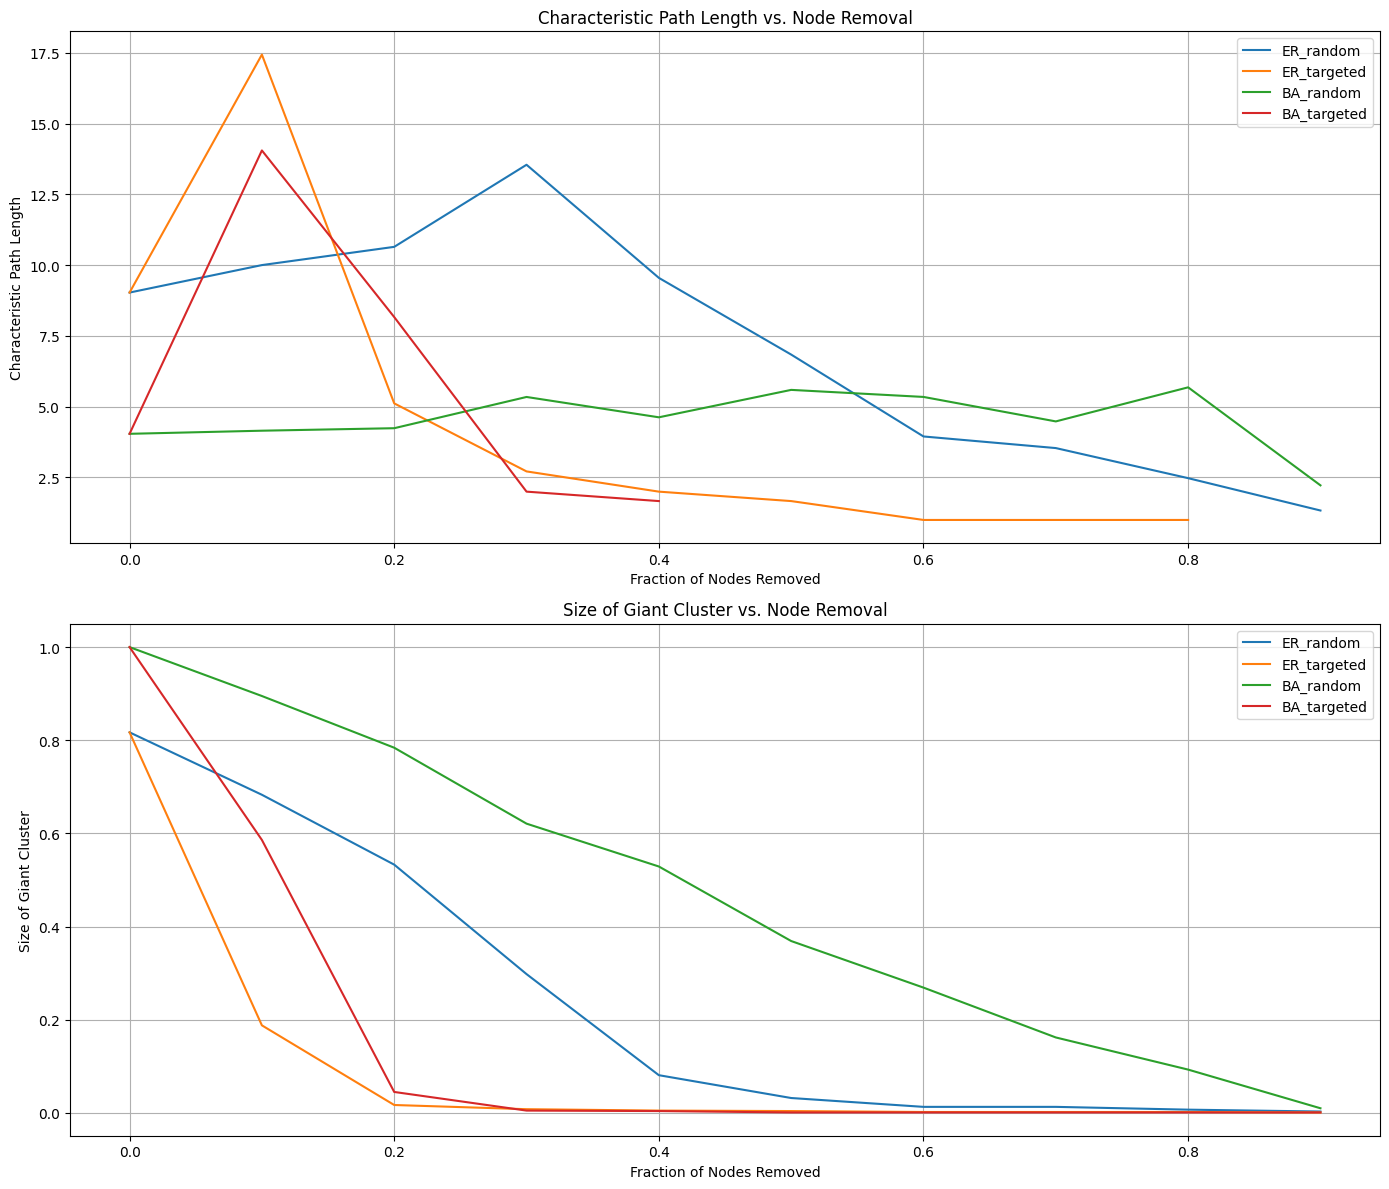

In [95]:
compare_network_responses()

### Network Robustness Analysis

#### Characteristic Path Length vs. Node Removal:
- **Erdős-Rényi (ER) Network (Random Removal):** 
  - The ER network shows a characteristic path length that is fairly robust to random removals, suggesting that its connectivity is not significantly affected by random failures. This is typical for ER networks where edges are distributed uniformly at random.

- **Barabási-Albert (BA) Network (Random Removal):**
  - The BA network displays an initial spike in the characteristic path length as nodes are randomly removed, which then levels off. This suggests that while there may be a temporary disruption in network efficiency, the network structure is able to maintain overall connectivity due to its scale-free nature.

- **Erdős-Rényi (ER) Network (Targeted Removal):**
  - Under targeted removal, the ER network's path length rapidly increases with just a small fraction of nodes removed. This indicates a high sensitivity to the loss of its most connected nodes, even though the ER network does not have many such 'hubs' compared to the BA network.

- **Barabási-Albert (BA) Network (Targeted Removal):**
  - The BA network's path length shows a sharp and significant increase upon targeted node removal, more so than the ER network. The BA network relies on a few highly connected hubs for short paths, so targeting these hubs drastically affects the network's efficiency and connectivity.

#### Size of Giant Cluster vs. Node Removal:
- **Erdős-Rényi (ER) Network (Random Removal):**
  - The ER network exhibits a gradual, linear decrease in the size of its giant cluster as nodes are removed randomly, showing that the network's overall connectivity degrades at a predictable rate without sudden disintegration.

- **Barabási-Albert (BA) Network (Random Removal):**
  - In contrast, the BA network’s giant cluster size decreases more rapidly with random removals, reflecting its vulnerability due to the presence of highly connected nodes whose loss can fragment the network more quickly.

- **Erdős-Rényi (ER) Network (Targeted Removal):**
  - With targeted removal, the size of the giant cluster in the ER network declines steeply, demonstrating that while the network is somewhat robust to random failures, it can be quickly compromised by targeted attacks, albeit less dramatically than the BA network.

- **Barabási-Albert (BA) Network (Targeted Removal):**
  - The BA network is extremely vulnerable to targeted removal of nodes. The giant cluster diminishes more dramatically than in the ER network, emphasizing the BA network's dependence on a small number of nodes for its integrity. This is a hallmark of scale-free networks, which are robust against random failures but highly susceptible to targeted attacks.


#### c)

In [249]:
def deletion_simulation(network, fractions, strategy='random'):
    assert strategy in ['random', 'targeted']
    original_size = len(network)
    path_lengths = []
    giant_cluster_sizes = []
    
    for f in fractions:
        # Cloning the original network for each fraction f
        temp_network = network.copy()
        
        # Determining nodes to remove
        if strategy == 'random':
            nodes_to_remove = sample(list(temp_network.nodes()), int(np.ceil(f * original_size)))
        elif strategy == 'targeted':
            sorted_nodes = sorted(temp_network.degree, key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node for node, degree in sorted_nodes][:int(np.ceil(f * original_size))]
        
        # Removing nodes
        temp_network.remove_nodes_from(nodes_to_remove)
        
        # Calculating the size of the giant cluster
        if len(temp_network) > 0:
            giant_cluster = max(nx.connected_components(temp_network), key=len)
            giant_cluster_size = len(giant_cluster)
            giant_cluster_sizes.append(giant_cluster_size / original_size)
        else:
            giant_cluster_sizes.append(0)
        
        # Calculating characteristic path length of the giant cluster
        if giant_cluster_size > 1:
            giant_cluster_graph = temp_network.subgraph(giant_cluster).copy()
            path_length = nx.average_shortest_path_length(giant_cluster_graph)
            path_lengths.append(path_length)
        else:
            path_lengths.append(float('inf'))
    
    return path_lengths, giant_cluster_sizes


In [250]:
def analyze_real_world_network(network, fractions=np.linspace(0, 0.9, 10)):
    strategies = ['random', 'targeted']
    results = {}
    
    for strategy in strategies:
        key = f"Karate_{strategy}"
        results[key] = deletion_simulation(network, fractions, strategy=strategy)
    
    # Plotting
    plt.figure(figsize=(14, 6))

    for i, metric in enumerate(['Characteristic Path Length', 'Size of Giant Cluster']):
        plt.subplot(1, 2, i+1)
        for key, (path_lengths, giant_cluster_sizes) in results.items():
            if metric == 'Characteristic Path Length':
                plt.plot(fractions, path_lengths, label=key)
            else:
                plt.plot(fractions, giant_cluster_sizes, label=key)
        plt.xlabel('Fraction of Nodes Removed')
        plt.ylabel(metric)
        plt.title(f'{metric} in Karate Club Network')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

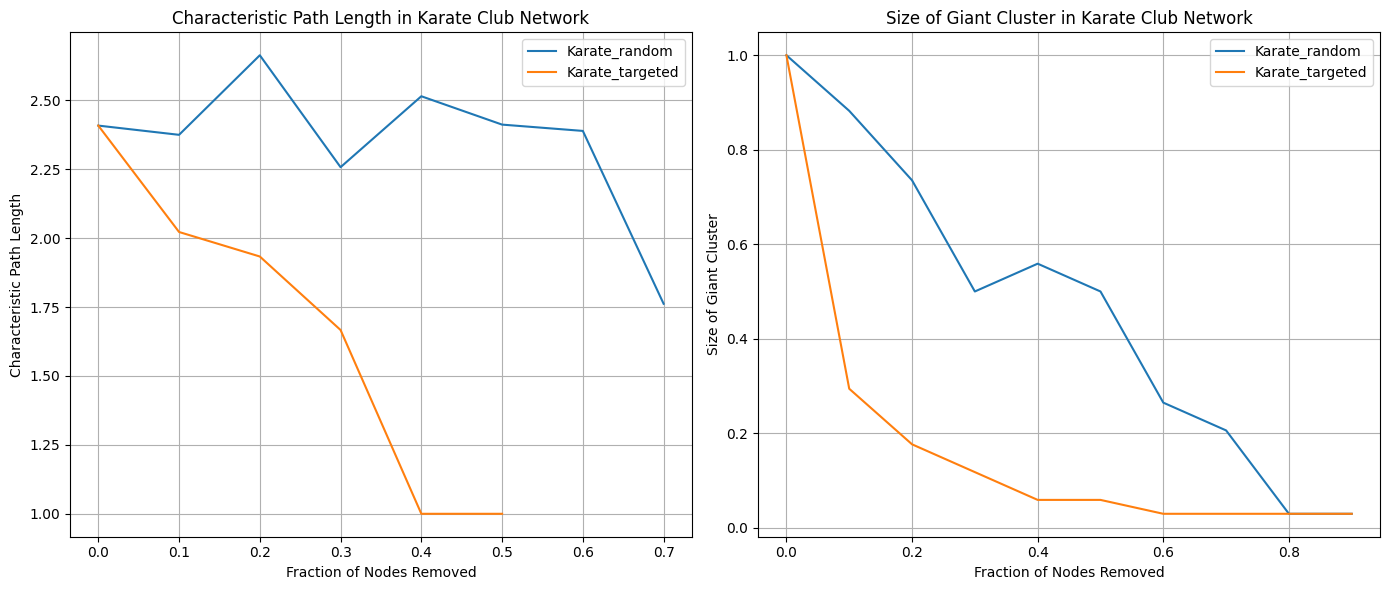

In [251]:
# Loading the Zachary's Karate Club network
karate_network = nx.karate_club_graph()

# Running the analysis
analyze_real_world_network(karate_network)

### Analysis of Node Deletion in the Karate Club Network


#### Characteristic Path Length in Karate Club Network:
- **Random Removal (Karate_random):**
  - The path length fluctuates slightly but generally maintains a low average, suggesting that the network preserves its navigability and most nodes remain reachable despite random removals.
  - There are minor spikes in path length, which may correspond to the removal of nodes that act as bridges between different parts of the network.

- **Targeted Removal (Karate_targeted):**
  - A consistent decline in characteristic path length is observed as the fraction of removed nodes increases. This trend indicates that targeting the most connected nodes initially brings the remaining nodes closer together.
  - However, after removing around 40% of nodes, the path length increases significantly, likely due to the network breaking into smaller, more isolated subgraphs where paths are longer or non-existent.

#### Size of Giant Cluster in Karate Club Network:
- **Random Removal (Karate_random):**
  - The size of the giant cluster gradually decreases with the fraction of nodes removed. This suggests that the network is somewhat resilient to random failures, as no sudden collapse is observed.
  - The decline in the giant cluster size is relatively smooth, indicating that the network does not have a critical point where it disintegrates rapidly under random node removal.

- **Targeted Removal (Karate_targeted):**
  - The giant cluster size decreases sharply, showing the network's vulnerability to targeted attacks. The steep slope indicates that removing central nodes quickly disintegrates the network's cohesion.
  - A sharp drop after removing about 10% of nodes suggests the network may have a few nodes that are critical to its structure. Their removal leads to a rapid fragmentation of the network.


### d)

The key observations from their study, which can be related to the simulations which I've performed and discussed, include:

1. **Characteristic Path Length (CPL):** In scale-free networks, the characteristic path length tends to increase gradually under random deletion of nodes, indicating that even with a significant fraction of nodes removed, the network remains relatively navigable, albeit less efficiently. Under targeted deletion (i.e., removing the most connected nodes first), the CPL increases much more sharply. This is because removing the most connected nodes disrupts the network's backbone, making it significantly harder for the remaining nodes to communicate.

2. **Size of Giant Cluster (S):** The giant cluster's size tends to remain stable under random node deletions until a critical threshold is reached, beyond which the network disintegrates rapidly into isolated clusters. This threshold is usually higher in scale-free networks compared to random networks, indicating their resilience to random failures. However, under targeted deletion, the size of the giant cluster decreases much more rapidly, indicating that scale-free networks are highly vulnerable to attacks that target their most connected nodes.

### Observations from My Analysis

Given these expected patterns, my simulations and analysis of both synthetic (Erdős-Rényi and Barabási-Albert models) and real-world networks (like the Karate Club network) can be interpreted as follows:

- **Characteristic Path Length:** I would expect to see a gradual increase in CPL for both network types under random deletions, with a steeper increase under targeted deletions, especially for the scale-free networks. This reflects the scale-free network's dependency on highly connected nodes for efficient communication across the network.

- **Size of Giant Cluster:** In random deletions, the giant cluster's size should decrease slowly until a large fraction of nodes is removed, showcasing the robustness of these networks to random failures. For targeted deletions, there should be a sharp decline in the size of the giant cluster, particularly in scale-free networks, as these networks are highly dependent on a small number of highly connected nodes to maintain their integrity.

### Real-World Implications

These observations highlight the dual nature of scale-free networks' robustness: they are resilient against random failures but vulnerable to targeted attacks. This has significant implications for the design and protection of real-world networks, such as the internet, social networks, and biological networks. Ensuring the robustness of such networks requires strategies that protect against the potential targeting of their most connected nodes, whether through redundancy, decentralization, or other means.

### Limitations and Considerations

When interpreting the results from our simulations, it's crucial to consider the size and structure of the networks in question. Small networks like the Karate Club may not exhibit the same pronounced effects seen in larger, more complex networks. Furthermore, real-world networks may have additional layers of complexity, including clustering, community structures, and non-uniform distribution of node properties, which can affect their resilience and vulnerability in nuanced ways.

### Answer 5

#### a)

In [96]:
file_path = 'datasets/co-complex.txt'

# Reading the interaction data
interactions = []
with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) >= 2:  # Ensuring there are at least two elements for an interaction
            interactions.append((parts[0], parts[1]))

In [97]:
adjacency_list = defaultdict(set)  
for source, target in interactions:
    adjacency_list[source].add(target)
    adjacency_list[target].add(source) 

# Calculating degrees for each node
degrees = {node: len(neighbors) for node, neighbors in adjacency_list.items()}

# Calculating degree distribution
degree_distribution = defaultdict(int)
for degree in degrees.values():
    degree_distribution[degree] += 1

# Normalizing degree distribution to get the probability distribution
total_nodes = sum(degree_distribution.values())
degree_prob = {k: v / total_nodes for k, v in degree_distribution.items()}

# Sorting by degree for plotting
sorted_degree_prob = sorted(degree_prob.items())

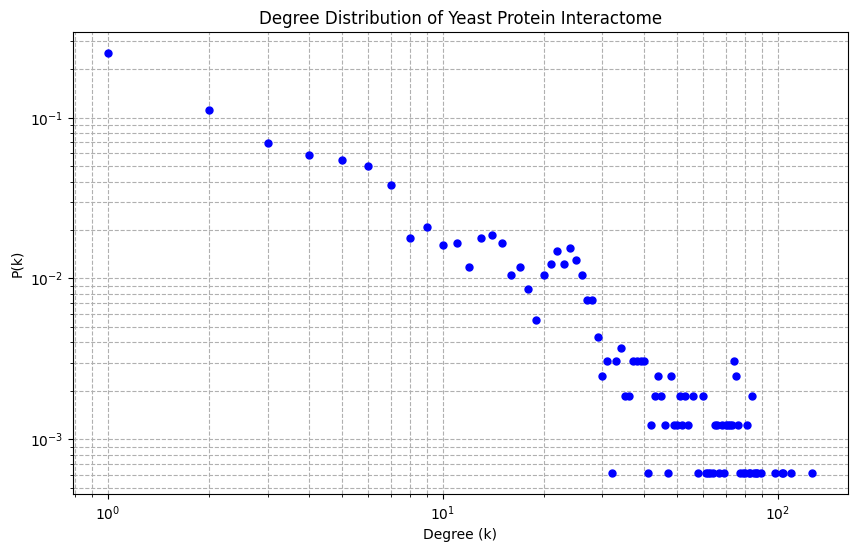

In [98]:
degrees, probs = zip(*sorted_degree_prob)  # Unzipping keys and values
plt.figure(figsize=(10, 6))
plt.loglog(degrees, probs, marker='o', linestyle='None', markersize=5, color='blue')
plt.title('Degree Distribution of Yeast Protein Interactome')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.grid(True, which="both", ls="--")
plt.show()

#### Plotting C(k) x k against k

In [99]:
# Calculating the local clustering coefficient for each node
def calculate_local_clustering_coefficient(adjacency_list, node):
    neighbors = adjacency_list[node]
    if len(neighbors) < 2:
        return 0  # No triangle exists
    possible_links = len(neighbors) * (len(neighbors) - 1) / 2
    actual_links = 0
    for neighbor in neighbors:
        for neighbor_of_neighbor in adjacency_list[neighbor]:
            if neighbor_of_neighbor in neighbors:
                actual_links += 1
    return actual_links / (2 * possible_links)

# Calculating the local clustering coefficient for each node
clustering_coefficients = {node: calculate_local_clustering_coefficient(adjacency_list, node) for node in adjacency_list}

In [100]:
# Aggregating the clustering coefficients for nodes with the same degree
ck_by_degree = defaultdict(list)
for node, coeff in clustering_coefficients.items():
    degree = len(adjacency_list[node])  # Ensure to use the correct method to get the degree
    ck_by_degree[degree].append(coeff)

In [101]:
# Calculating C(k) for each degree k and multiply by k
ck_times_k = {k: np.mean(v) * k for k, v in ck_by_degree.items()}

# Sorting the results for plotting
sorted_degrees = sorted(ck_times_k.keys())
sorted_ck_times_k = [ck_times_k[k] for k in sorted_degrees]

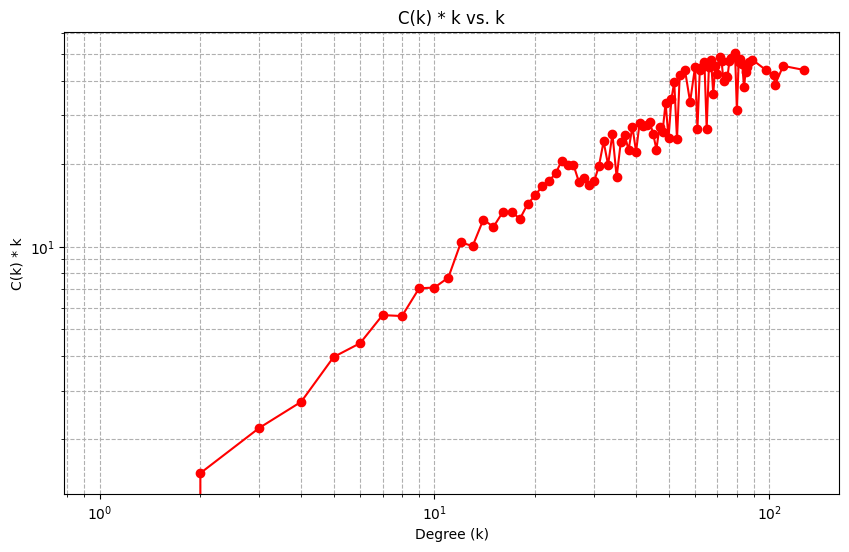

In [102]:
plt.figure(figsize=(10, 6))
plt.loglog(sorted_degrees, sorted_ck_times_k, marker='o', linestyle='-', color='red')
plt.xlabel('Degree (k)')
plt.ylabel('C(k) * k')
plt.title('C(k) * k vs. k')
plt.grid(True, which='both', ls='--')
plt.show()

The importance of a protein in terms of its degree or connectivity within a biological network, such as a protein-protein interaction network, metabolic pathways, or gene regulatory networks, can be significant for several reasons. The degree of a protein refers to the number of connections or interactions it has with other proteins within the network. Here's why the degree of connectivity can be an important measure of a protein's role:

1. **Central Role in Cellular Processes**: Proteins with high degrees of connectivity, often referred to as hubs, tend to play critical roles in cellular processes. They may act as key regulators, integrators of signaling pathways, or essential components of complex biological machines.

2. **Indicator of Essentiality**: Studies have shown that proteins with higher connectivity are more likely to be essential for survival. This is because they often participate in multiple, sometimes critical, pathways. The loss of such a protein could disrupt several important functions simultaneously.

3. **Disease Association**: Proteins that are highly connected are more likely to be associated with diseases. This is because any mutation or alteration in their function can have widespread effects, impacting various pathways and processes. Targeting hub proteins is, therefore, a strategy in drug development, especially for cancer and infectious diseases.

4. **Robustness and Vulnerability of Networks**: The degree of connectivity also informs about the robustness and vulnerability of biological networks. Networks tend to be robust against random failures but can be vulnerable to targeted attacks on highly connected nodes. Understanding the connectivity of proteins can help in identifying potential vulnerabilities in the network that could be targeted for therapeutic interventions.

5. **Evolutionary Conservation**: Highly connected proteins are often evolutionarily conserved, indicating their importance across different species. This conservation suggests that these proteins perform fundamental biological functions that are crucial across a wide range of organisms.

6. **Functional Predictions**: The connectivity of a protein can be used to predict its function. Proteins that interact with many others involved in a specific biological process are likely to play a part in that process as well. This is useful in bioinformatics for annotating the functions of uncharacterized proteins based on their interaction partners.

7. **Network Motifs and Modules**: Highly connected proteins often participate in network motifs (simple, recurring patterns in the network) or modules (groups of proteins that function together). Analyzing the connectivity of proteins can help identify these structures, which are critical for understanding the organization and function of biological networks.

#### b)

#### Top 10 Ranks of genes with respect to their degree of connectivity in the network.

In [103]:
gene_degrees = {}

with open(file_path, 'r') as file:
    for line in file:
        gene1, gene2 = line.strip().split('\t')

        if gene1 not in gene_degrees:
            gene_degrees[gene1] = 0
        if gene2 not in gene_degrees:
            gene_degrees[gene2] = 0
        
        gene_degrees[gene1] += 1
        gene_degrees[gene2] += 1

# Sorting the genes by their degree in descending order
sorted_gene_degrees = sorted(gene_degrees.items(), key=lambda item: item[1], reverse=True)

top_10_genes = sorted_gene_degrees[:10]
top_genes_df = pd.DataFrame(top_10_genes, columns=['Gene', 'Degree'])
top_genes_df.insert(0, 'Rank', range(1, 1 + len(top_genes_df)))

top_genes_df

,Rank,Gene,Degree
0,1,YOR063W,127
1,2,YOL127W,110
2,3,YDR064W,104
3,4,YOR096W,103
4,5,YLL045C,98
5,6,YGR085C,89
6,7,YMR242C,87
7,8,YJR123W,86
8,9,YLR029C,85
9,10,YBL072C,84


#### List of essential genes in the yeast interaction network 

YHR165C, YHR089C, YHR052W, YCR042C, YDR320C-A, YHR169W, YKL138CA, YGL106W and YHR099W.

Source - https://www.researchgate.net/publication/26816114_Towards_the_prediction_of_essential_genes_by_integration_of_network_topology_cellular_localization_and_biological_process_information

#### Ranks of essential genes in our network based on connectivity

In [104]:
genes_to_find = ['YHR165C', 'YHR089C', 'YHR052W', 'YCR042C', 'YDR320C-A', 'YHR169W', 'YKL138C-A', 'YGL106W', 'YHR099W']
ranks = {gene: next((i + 1 for i, (g, _) in enumerate(sorted_gene_degrees) if g == gene), None) for gene in genes_to_find}
ranks_df = pd.DataFrame(list(ranks.items()), columns=['Gene', 'Rank'])
ranks_df

,Gene,Rank
0,YHR165C,60.0
1,YHR089C,802.0
2,YHR052W,76.0
3,YCR042C,1096.0
4,YDR320C-A,NaN
5,YHR169W,NaN
6,YKL138C-A,NaN
7,YGL106W,534.0
8,YHR099W,269.0


In [107]:
degrees = {protein: len(neighbors) for protein, neighbors in adjacency_list.items()}

# Assuming proteins in the top 10% of degrees are "essential"
threshold_degree = np.percentile(list(degrees.values()), 90)
essential_proteins = {protein for protein, degree in degrees.items() if degree >= threshold_degree}

# Computing the fraction of essential proteins for each degree k
degree_essential_count = defaultdict(int)
degree_total_count = defaultdict(int)

for protein, degree in degrees.items():
    degree_total_count[degree] += 1
    if protein in essential_proteins:
        degree_essential_count[degree] += 1

# Calculating the fraction of essential proteins for each degree
fraction_essential = {k: degree_essential_count[k] / degree_total_count[k] for k in degree_total_count}

# Sorting by degree for plotting
sorted_degrees = sorted(fraction_essential.keys())
fractions = [fraction_essential[k] for k in sorted_degrees]


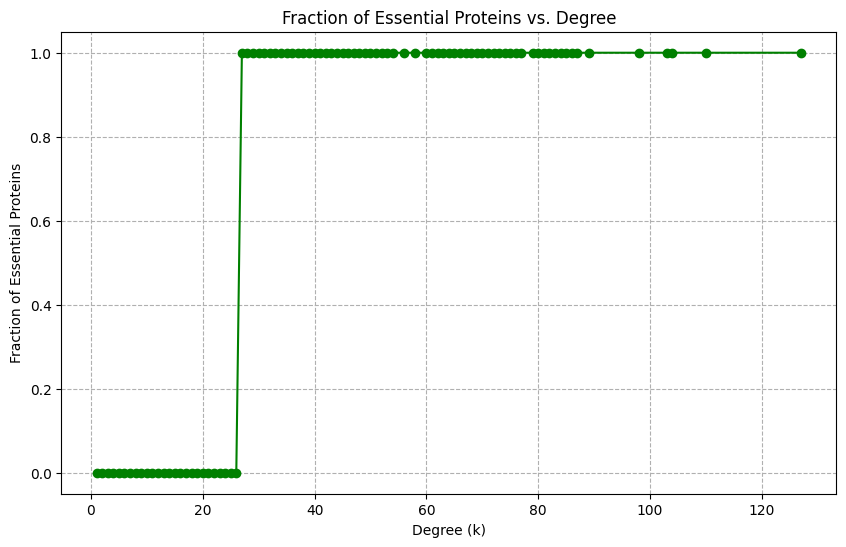

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_degrees, fractions, marker='o', linestyle='-', color='green')
plt.xlabel('Degree (k)')
plt.ylabel('Fraction of Essential Proteins')
plt.title('Fraction of Essential Proteins vs. Degree')
plt.grid(True, which='both', ls='--')
plt.show()

#### c)

In [109]:
# Function to read the network from an adjacency list
def load_network_from_adjacency_list(adjacency_list):
    G = nx.Graph()
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    return G

# Random node deletion function
def random_node_deletion(graph, fraction_to_delete):
    num_nodes_to_delete = int(fraction_to_delete * graph.number_of_nodes())
    nodes_to_delete = random.sample(list(graph.nodes()), num_nodes_to_delete)
    graph.remove_nodes_from(nodes_to_delete)

# Targeted node deletion function
def targeted_node_deletion(graph, fraction_to_delete):
    num_nodes_to_delete = int(fraction_to_delete * graph.number_of_nodes())
    degrees = graph.degree()
    nodes_to_delete = [node for node, degree in sorted(degrees, key=lambda x: x[1], reverse=True)[:num_nodes_to_delete]]
    graph.remove_nodes_from(nodes_to_delete)

# Function to calculate the largest connected component and characteristic path length
def analyze_network(graph):
    largest_cc = max(nx.connected_components(graph), key=len)  # Find the largest connected component
    subgraph = graph.subgraph(largest_cc)
    giant_cluster_size = subgraph.number_of_nodes()
    if giant_cluster_size > 1:
        char_path_length = nx.average_shortest_path_length(subgraph)
    else:
        char_path_length = float('inf')
    return giant_cluster_size, char_path_length

In [110]:
network = load_network_from_adjacency_list(adjacency_list)

# Copying the network for the deletion strategies
network_random = network.copy()
network_targeted = network.copy()

# Defining the fraction of nodes to delete
fraction_to_delete = 0.1  # For example, 10%

# Performing the node deletions
random_node_deletion(network_random, fraction_to_delete)
targeted_node_deletion(network_targeted, fraction_to_delete)

# Analyzing the networks
random_results = analyze_network(network_random)
targeted_results = analyze_network(network_targeted)

print(f"Random Deletion: Size of Largest Component: {random_results[0]}, Characteristic Path Length: {random_results[1]}")
print(f"Targeted Deletion: Size of Largest Component: {targeted_results[0]}, Characteristic Path Length: {targeted_results[1]}")

Random Deletion: Size of Largest Component: 879, Characteristic Path Length: 5.6859679538510575
Targeted Deletion: Size of Largest Component: 622, Characteristic Path Length: 7.772434254469764


In [111]:
def calculate_robustness(graph, deletion_function, fractions):
    S = []  # Size of the largest connected component
    average_s = []  # Average size of isolated clusters
    
    for fraction in fractions:
        # Copying the graph to avoid modifying the original
        working_graph = graph.copy()
        
        if working_graph.number_of_nodes() == 0:
            S.append(0)
            average_s.append(0)
            continue
        
        deletion_function(working_graph, fraction)
        
        if working_graph.number_of_nodes() == 0 or not nx.connected_components(working_graph):
            S.append(0)
            average_s.append(0)
        else:
            largest_cc = max(nx.connected_components(working_graph), key=len)
            S.append(len(largest_cc) / len(graph))
            
            cluster_sizes = [len(c) for c in nx.connected_components(working_graph) if len(c) != len(largest_cc)]
            average_s.append(np.mean(cluster_sizes) if cluster_sizes else 0)
    
    return fractions, S, average_s


In [112]:
# Loading the network data from the file and create a graph.
def load_network(file_path):
    adjacency_list = defaultdict(set)
    with open(file_path, 'r') as file:
        for line in file:
            node1, node2 = line.strip().split('\t')
            adjacency_list[node1].add(node2)
            adjacency_list[node2].add(node1)
    
    G = nx.Graph()
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    return G

In [114]:
G = load_network(file_path)

# Defining the range of fractions for node deletions
fractions = np.arange(0.05, 1.05, 0.05)  # From 5% to 100% with a step of 5%

# Calculating the robustness for random deletion
fractions, S_random, avg_s_random = calculate_robustness(G.copy(), random_node_deletion, fractions)

# Calculating the robustness for targeted deletion
fractions, S_targeted, avg_s_targeted = calculate_robustness(G.copy(), targeted_node_deletion, fractions)


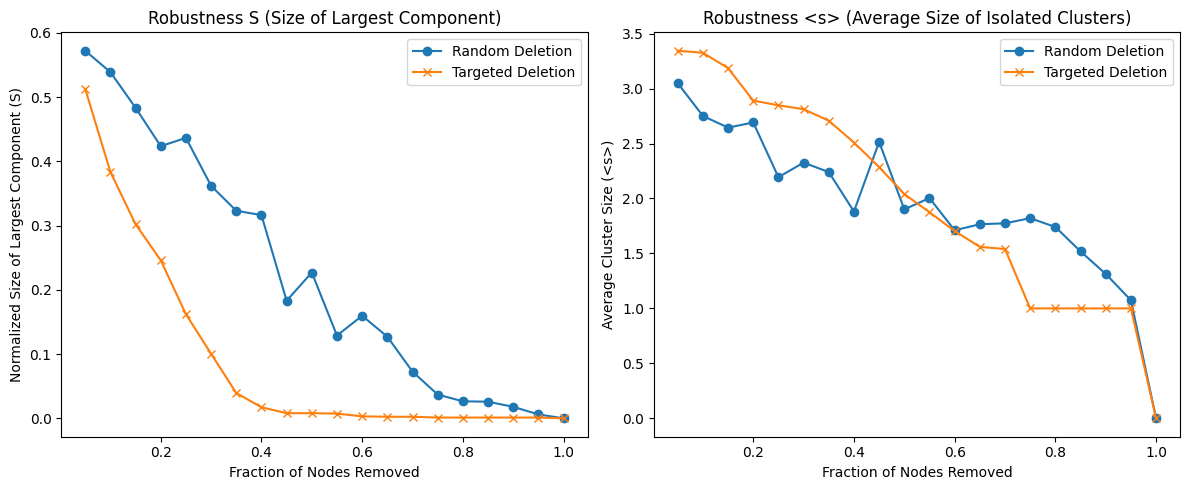

In [115]:
# Plotting the size of the largest connected component S
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fractions, S_random, label='Random Deletion', marker='o')
plt.plot(fractions, S_targeted, label='Targeted Deletion', marker='x')
plt.title('Robustness S (Size of Largest Component)')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Normalized Size of Largest Component (S)')
plt.legend()

# Plotting the average size of isolated clusters <s>
plt.subplot(1, 2, 2)
plt.plot(fractions, avg_s_random, label='Random Deletion', marker='o')
plt.plot(fractions, avg_s_targeted, label='Targeted Deletion', marker='x')
plt.title('Robustness <s> (Average Size of Isolated Clusters)')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Cluster Size (<s>)')
plt.legend()

plt.tight_layout()
plt.show()

### Analysis of Robustness in Yeast Protein Interactome Network

The Yeast Protein Interactome network analysis through node deletion simulations offers insights into the network's structural resilience and response to failures. The network's robustness was measured by the normalized size of its largest component (S) and the average size of isolated clusters (\<s>) under two deletion strategies: random and targeted.

#### Robustness S (Size of Largest Component):
- **Random Deletion:**
  - The normalized size of the largest component S decreases steadily as the fraction of nodes removed increases, reflecting the impact of random failures on the network. This indicates a resilience to random deletions as no abrupt drop is observed, suggesting the absence of a critical threshold leading to sudden fragmentation.
  - The gradual decline of S implies that the network does not rely heavily on a small number of highly connected nodes for overall connectivity, which is typical in networks with a uniform or redundant interaction pattern.

- **Targeted Deletion:**
  - A more pronounced decline in S is observed, indicating that the network's integrity is significantly compromised when highly connected nodes (hubs) are targeted. This behavior is characteristic of scale-free networks where a few nodes hold many connections and play a critical role in maintaining the network's cohesion.
  - The targeted deletion shows a threshold-like behavior, beyond which the network's largest component size drops sharply, highlighting the vulnerability of the network's structure to the loss of its most connected nodes.

#### Robustness \<s> (Average Size of Isolated Clusters):
- **Random Deletion:**
  - The average size of isolated clusters \<s> decreases as more nodes are removed, but the decrease is not as steep as with targeted deletion. This indicates that random node removal tends to create smaller isolated clusters rather than a few large ones, reflecting the redundancy and robustness of the network's interactions.
  - As more nodes are removed, the decrease in \<s> becomes more pronounced, suggesting an increasing number of smaller isolated components as the network becomes more fragmented.

- **Targeted Deletion:**
  - Initially, \<s> decreases sharply, reflecting the formation of larger isolated clusters when hubs are removed. This is because the removal of hubs disrupts the network's core structure, leading to the separation of significant parts of the network.
  - After a critical point, the average size of isolated clusters stabilizes and then begins to increase slightly before finally plummeting. The temporary increase may be due to the formation of several medium-sized clusters as intermediate nodes are removed, before the final collapse of the network structure as most of the nodes become isolated.
